Sampling rate (Hz): 48000
Number of samples: 171648
Duration (seconds): 3.576


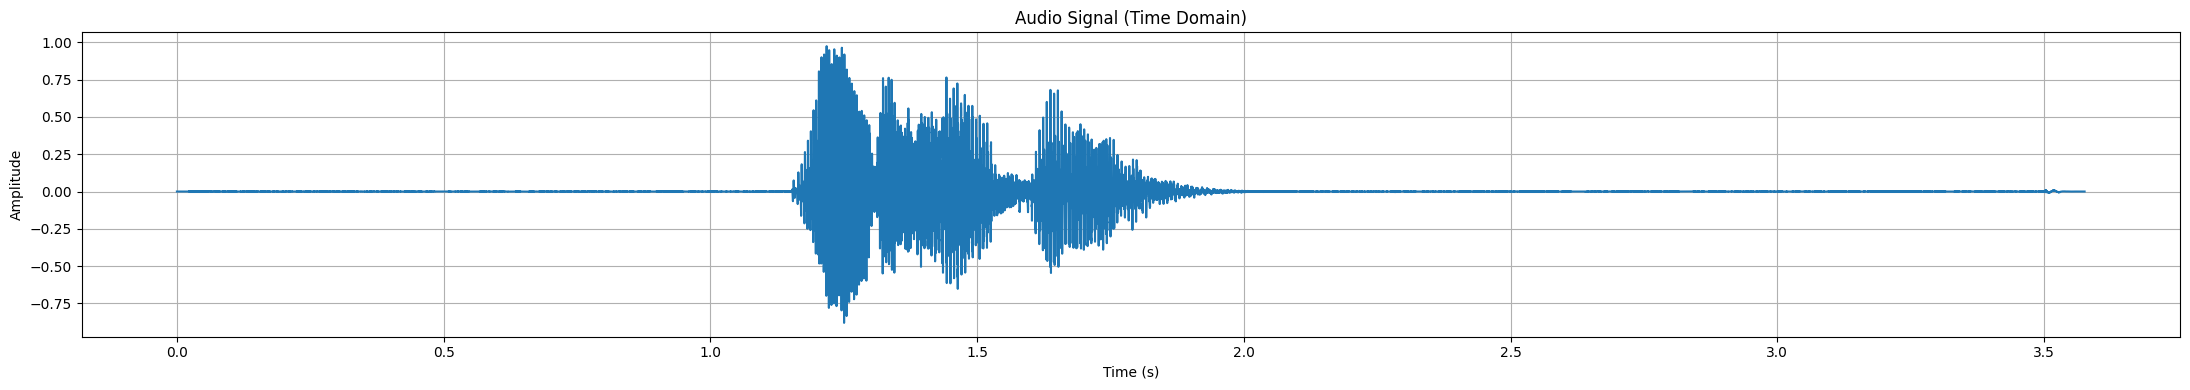

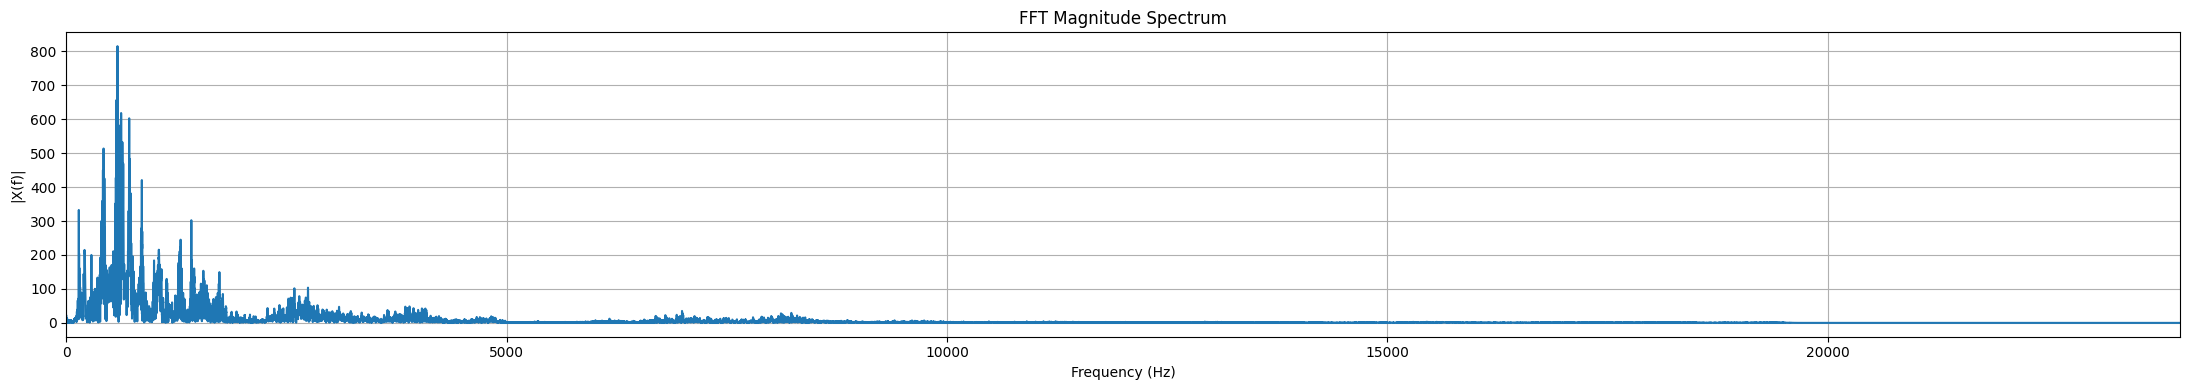

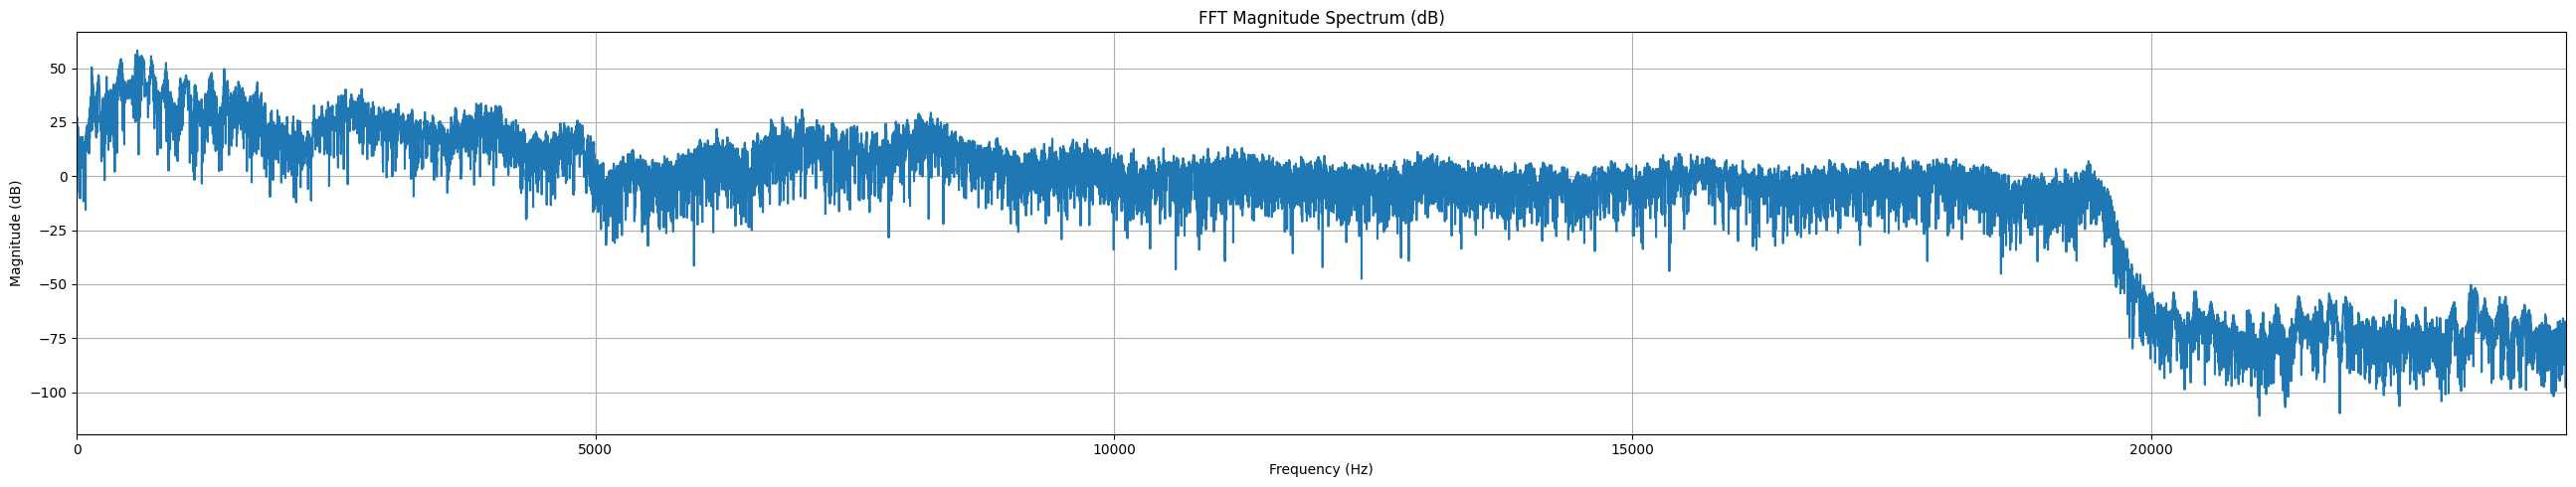

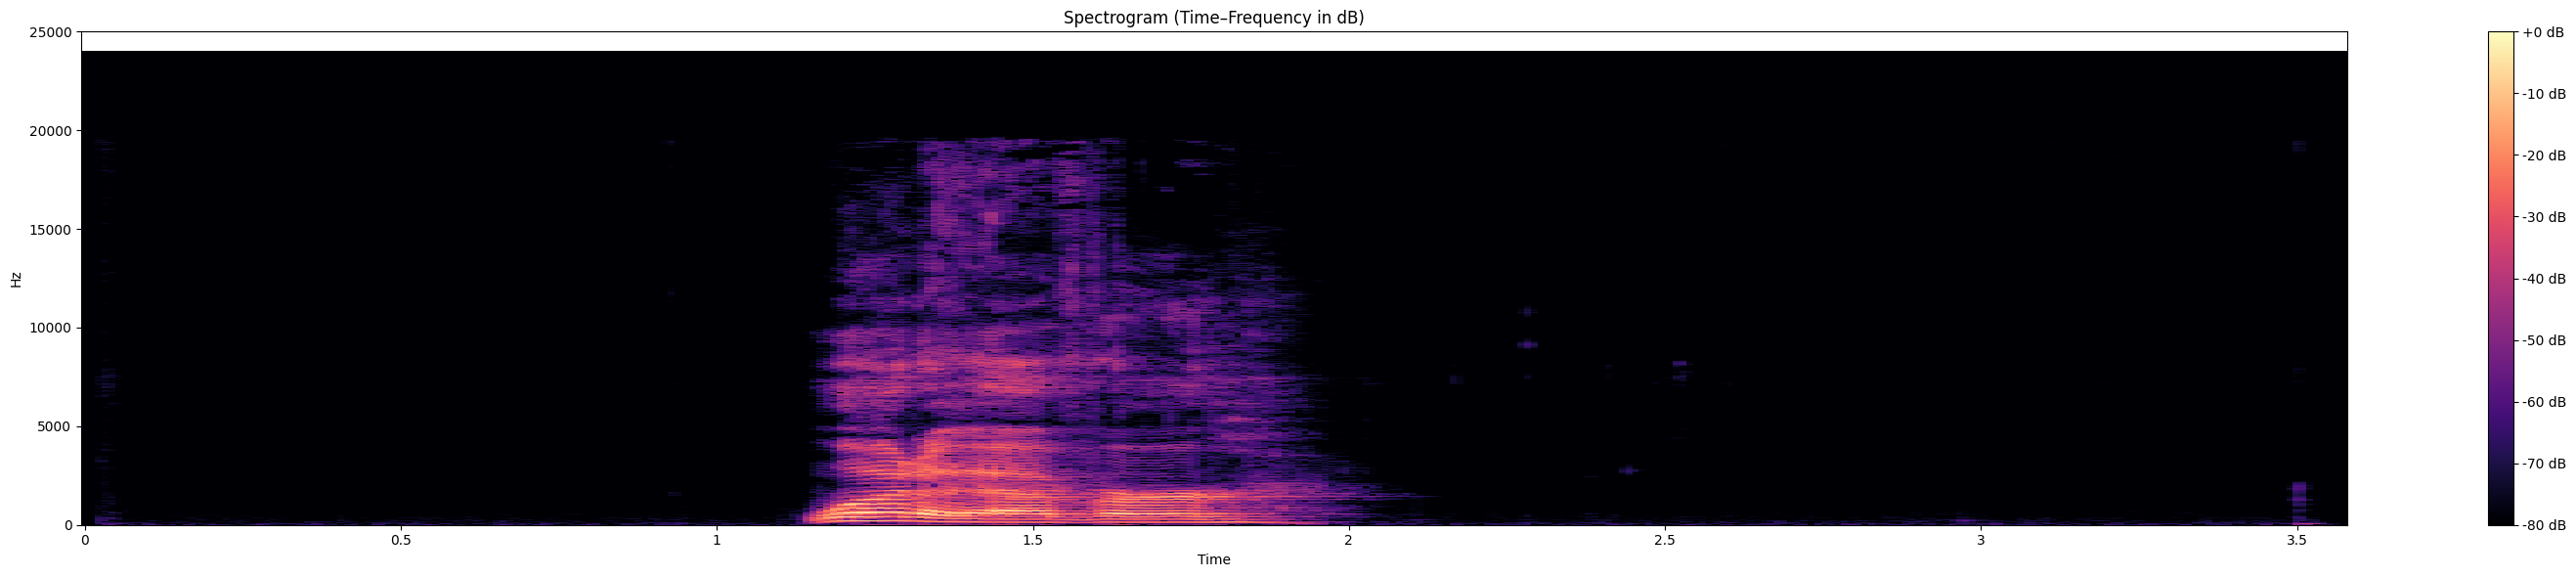

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# ===============================
# 1) LOAD AUDIO
# ===============================
audio_path = "/content/whatever.mp3"

x, sr = librosa.load(audio_path, sr=None, mono=True)

print("Sampling rate (Hz):", sr)
print("Number of samples:", len(x))
print("Duration (seconds):", len(x) / sr)

# ===============================
# 2) TIME DOMAIN
# ===============================
t = np.arange(len(x)) / sr

plt.figure(figsize=(22, 4))
plt.plot(t, x)
plt.title("Audio Signal (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 3) FFT (FREQUENCY DOMAIN)
# ===============================
N = len(x)
X = np.fft.rfft(x)
freqs = np.fft.rfftfreq(N, d=1/sr)

mag = np.abs(X)

# FFT linear scale
plt.figure(figsize=(22, 4))
plt.plot(freqs, mag)
plt.title("FFT Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|X(f)|")
plt.xlim(0, sr/2)
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 4) FFT IN dB (WIDE FIGURE)
# ===============================
eps = 1e-12
mag_db = 20 * np.log10(mag + eps)

plt.figure(figsize=(26, 5))   # VERY WIDE
plt.plot(freqs, mag_db)
plt.title("FFT Magnitude Spectrum (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, sr/2)
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 5) TIME–FREQUENCY (SPECTROGRAM)
# ===============================
n_fft = 2048
hop_length = 512

S = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))
S_db = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(30, 6))   # EXTRA WIDE FOR TIME
librosa.display.specshow(
    S_db,
    sr=sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="hz"
)
plt.colorbar(format="%+2.0f dB")
plt.ylim(0, 25000)  # voice band
plt.title("Spectrogram (Time–Frequency in dB)")
plt.tight_layout()
plt.show()



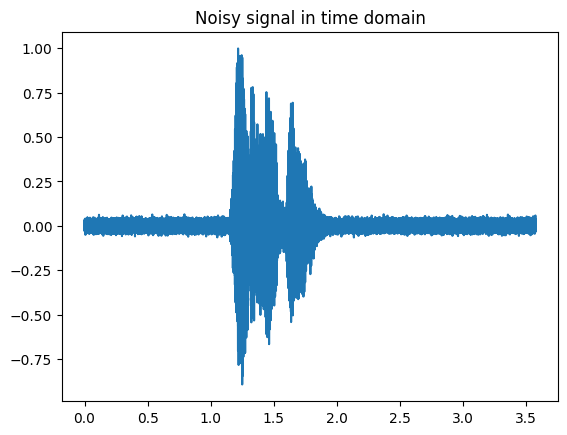

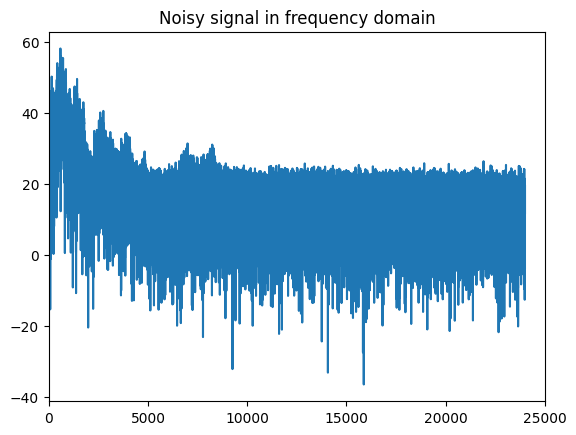

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import soundfile as sf
import librosa.display
# Load audio
audio_path = "/content/whatever.mp3"
clean_audio, sr = librosa.load(audio_path, sr=None, mono=True)

# Time array
t = np.arange(len(clean_audio)) / sr

# Ajouter du bruit blanc
noise = np.random.normal(0, 0.015, clean_audio.shape)
noisy_signal = clean_audio + noise

# Sauvegarder le signal bruité
sf.write("noisy_audio.wav", noisy_signal, sr)

# Time domain plot
plt.plot(t, noisy_signal)
plt.title("Noisy signal in time domain")
plt.show()

# FFT instead of signal.freqz
N = len(noisy_signal)
X = np.fft.rfft(noisy_signal)
freqs = np.fft.rfftfreq(N, d=1/sr)
mag_db = 20 * np.log10(np.abs(X) + 1e-12)

# Frequency domain plot
plt.plot(freqs, mag_db)
plt.title("Noisy signal in frequency domain")
plt.xlim(0, 25000)
plt.show()

# Save again
sf.write('noisy_audio.wav', noisy_signal, sr)

SNR for Rectangulaire: 15.69 dB


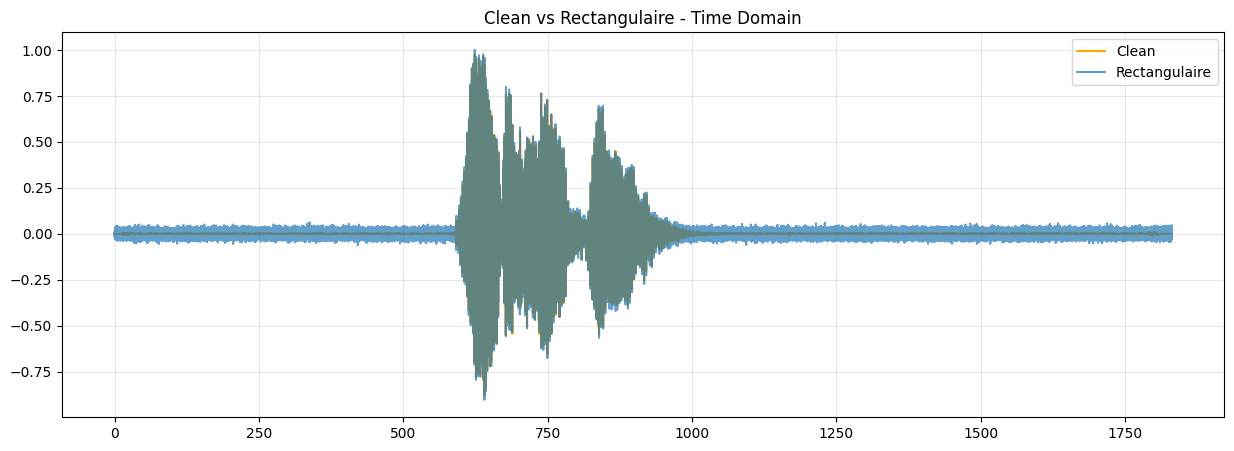

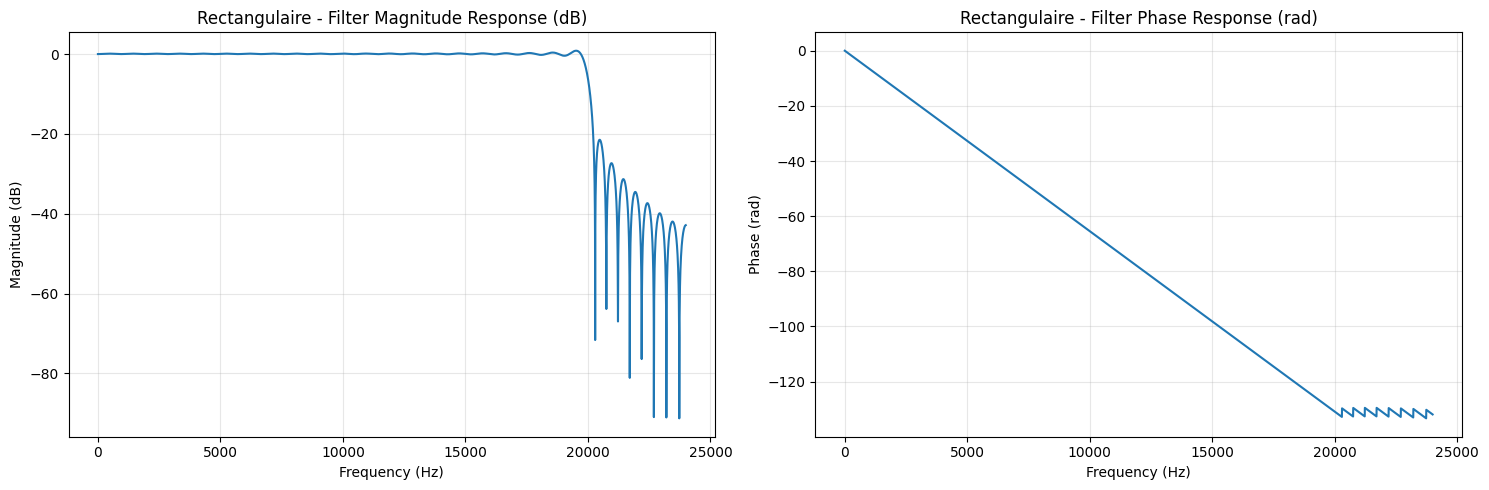

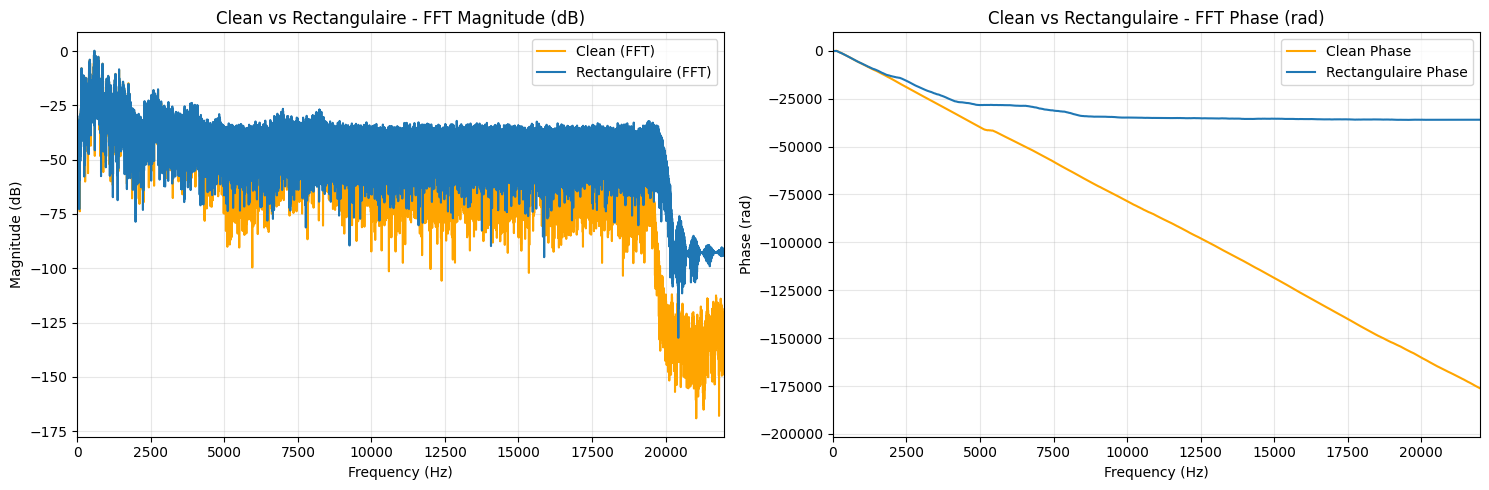

SNR for Triangulaire: 16.00 dB


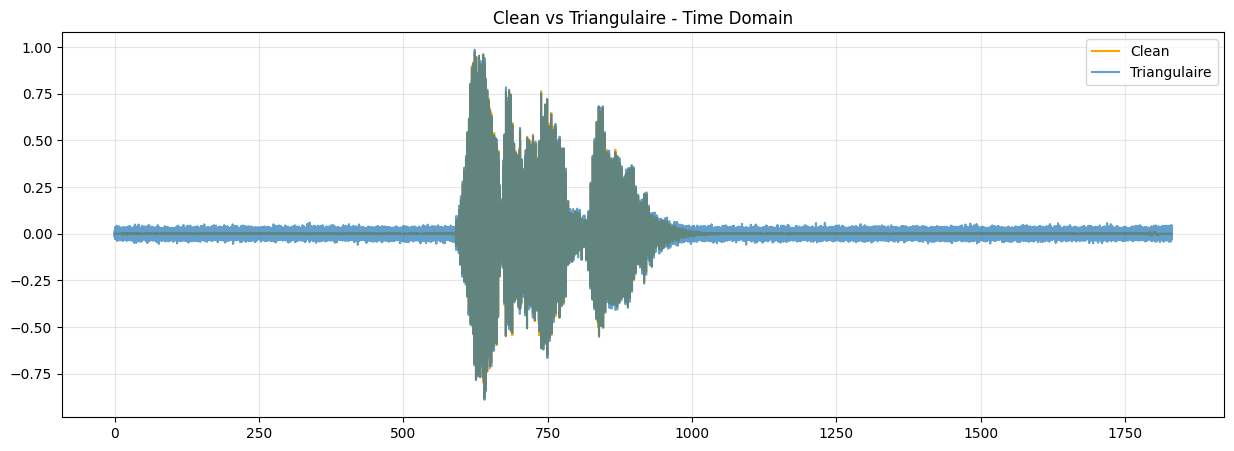

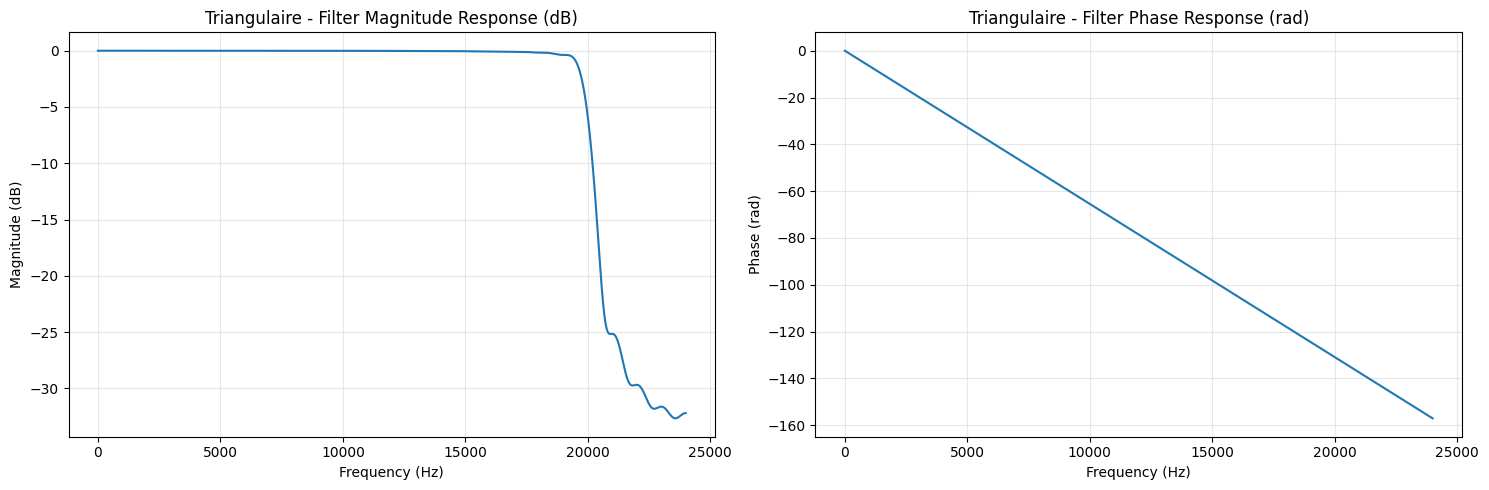

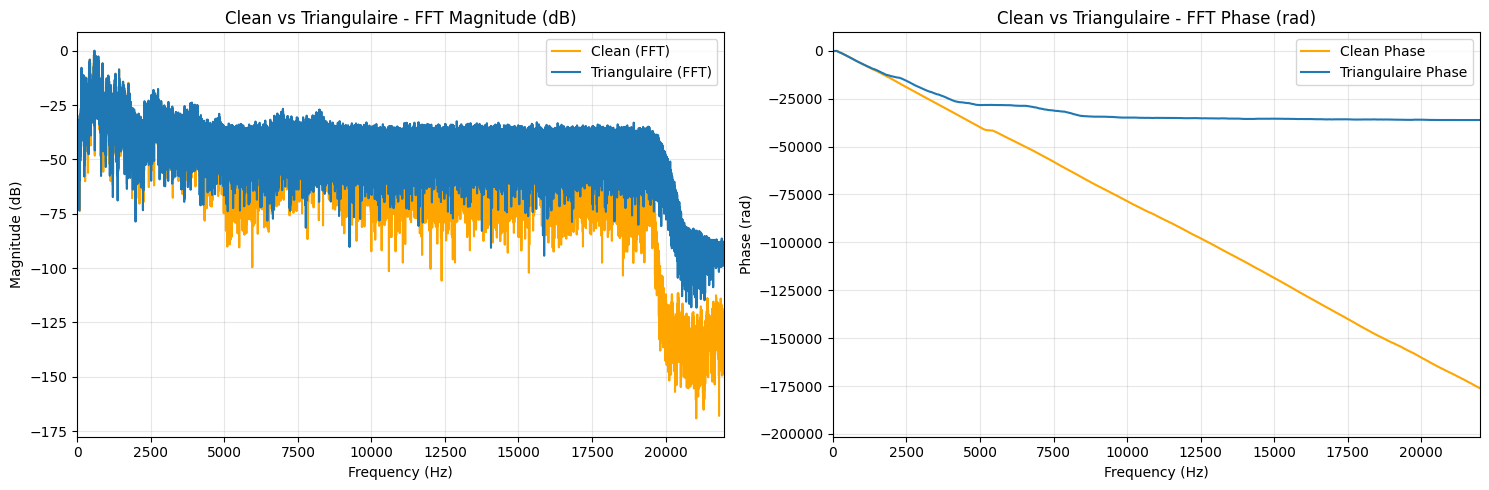

SNR for Parabolic: 15.95 dB


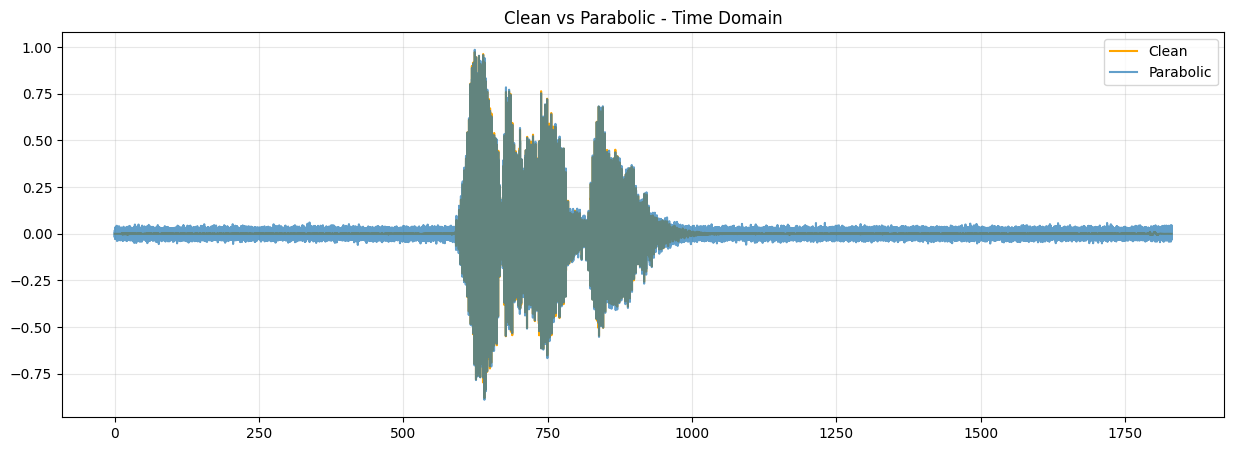

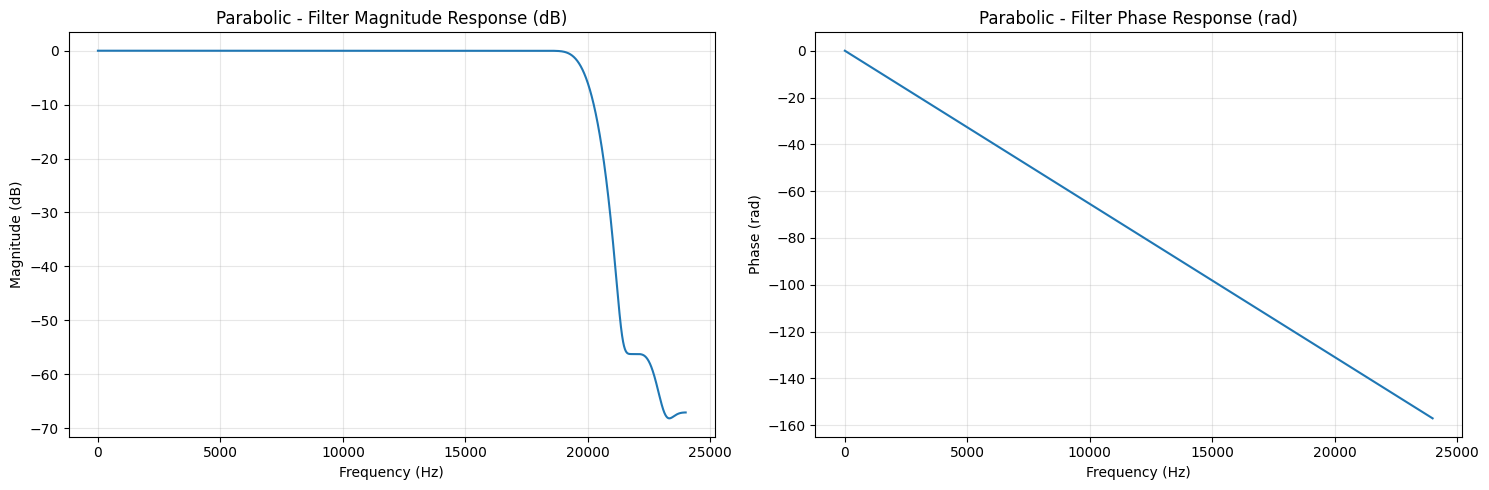

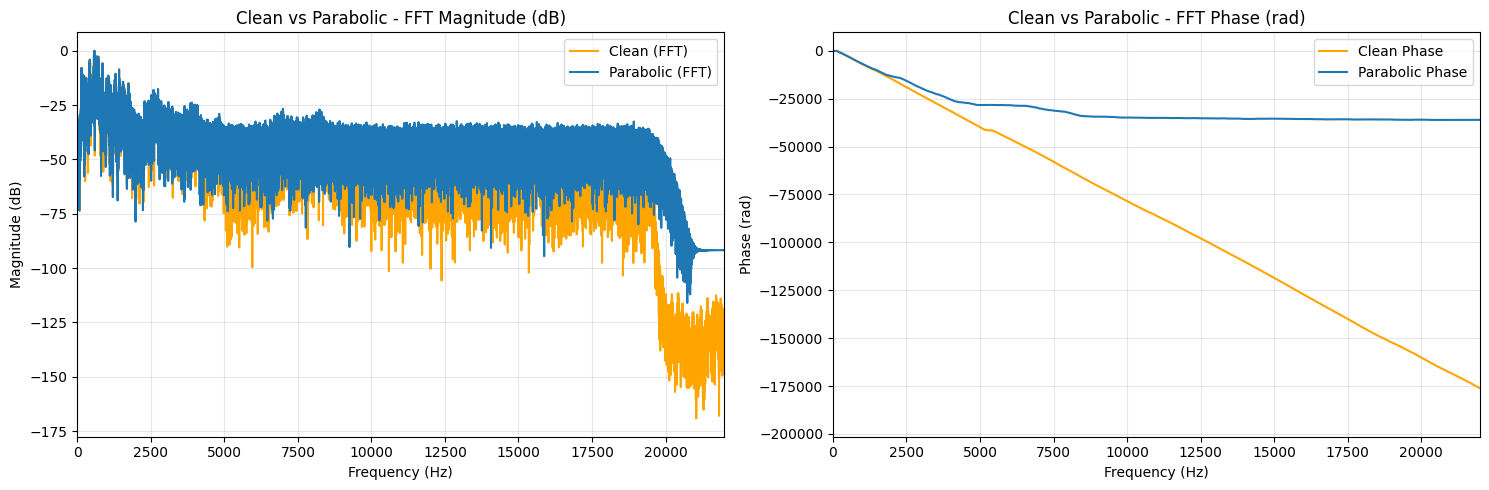

SNR for Polynomial: 15.96 dB


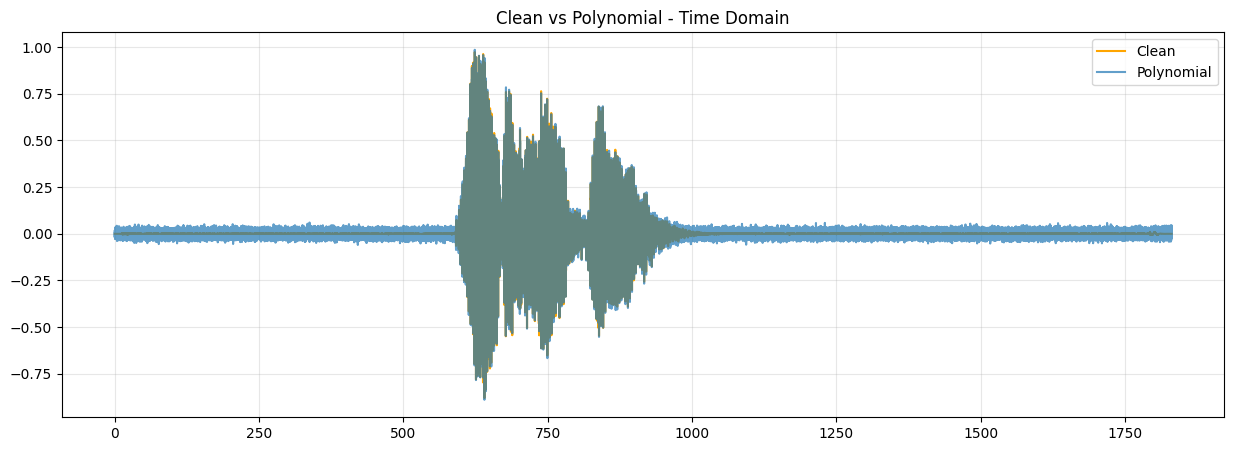

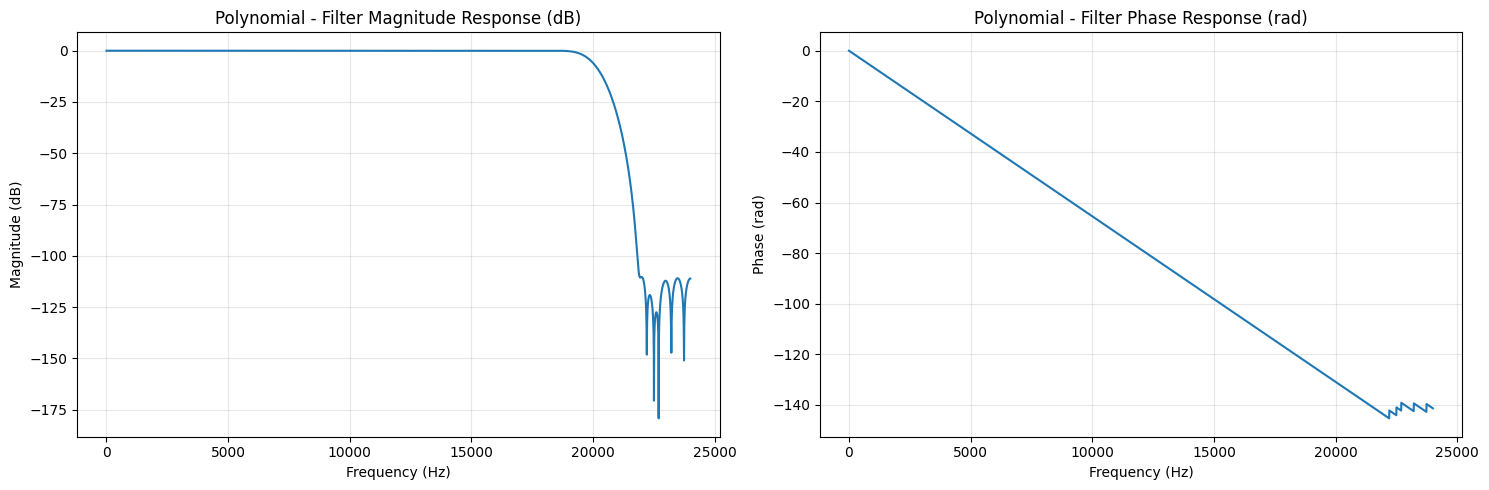

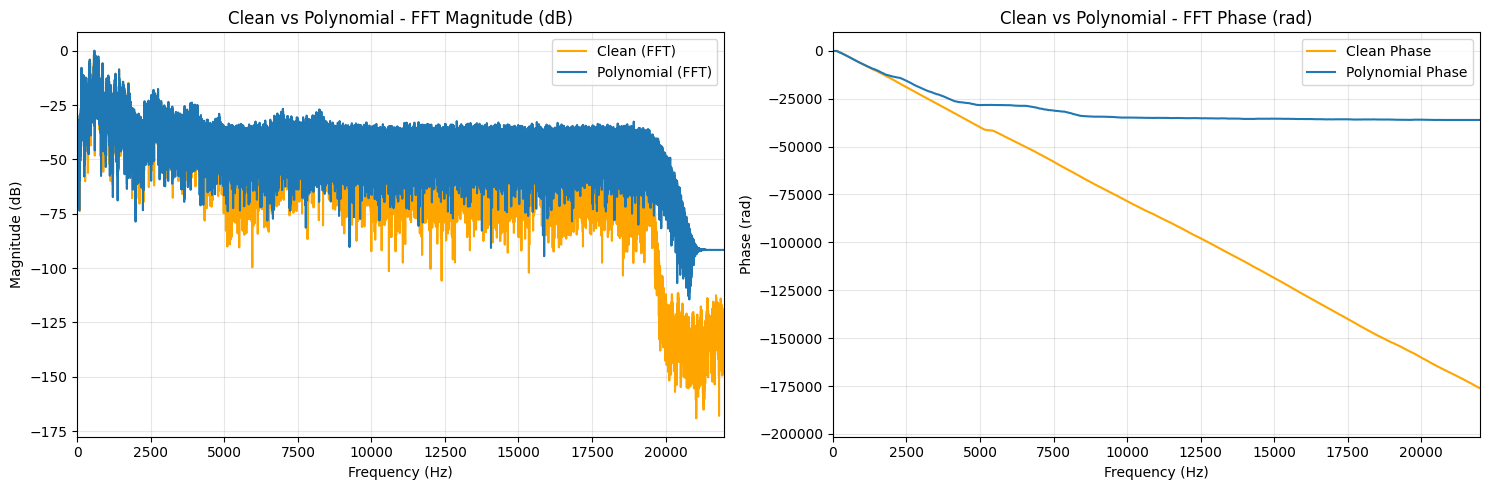

SNR for Cosine: 15.90 dB


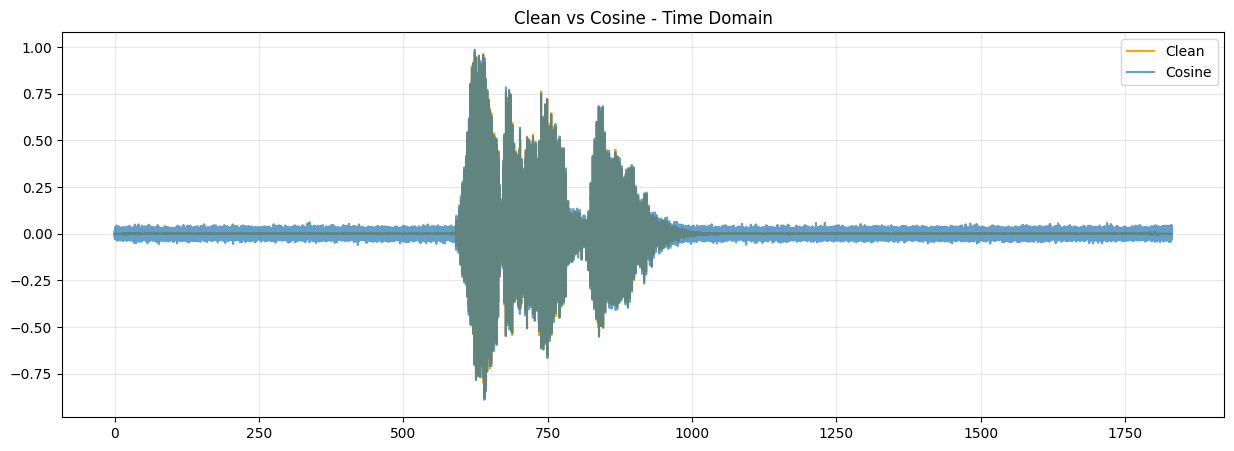

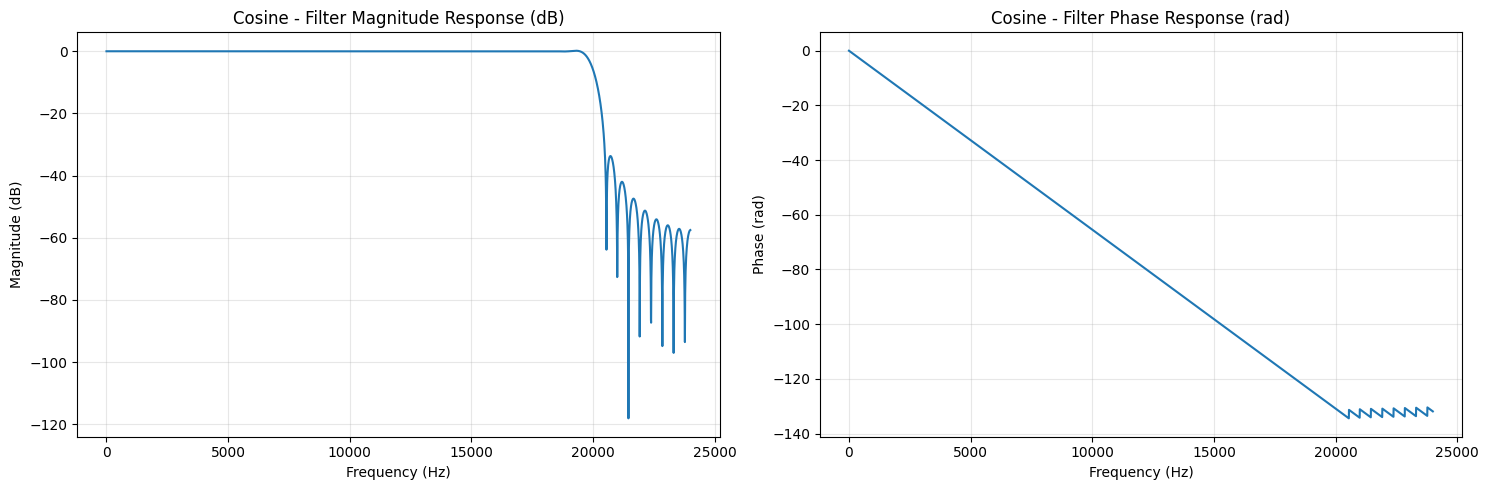

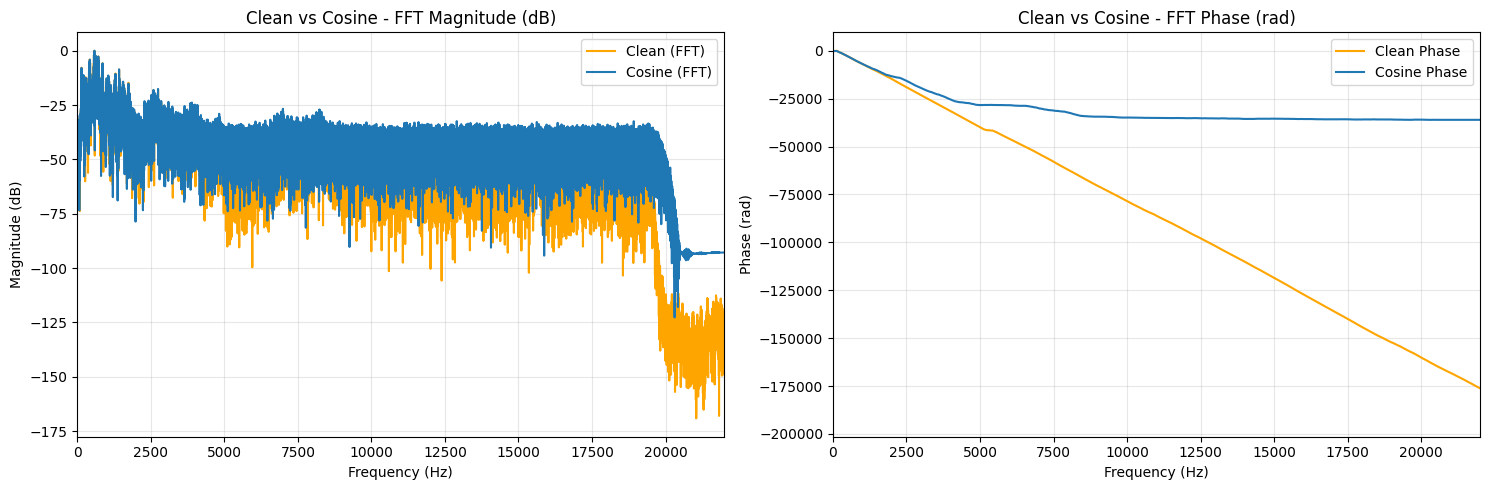

SNR for Hanning: 15.92 dB


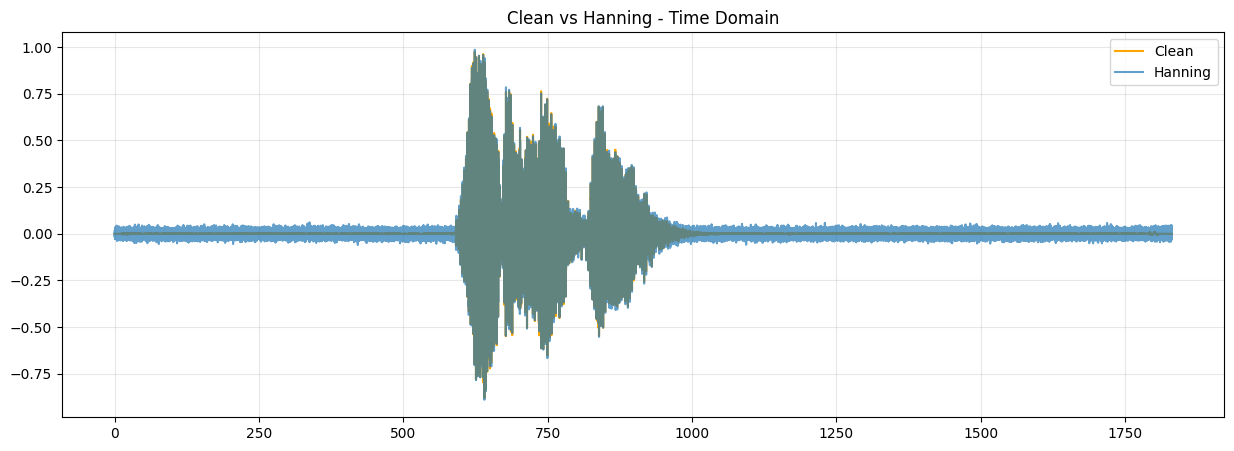

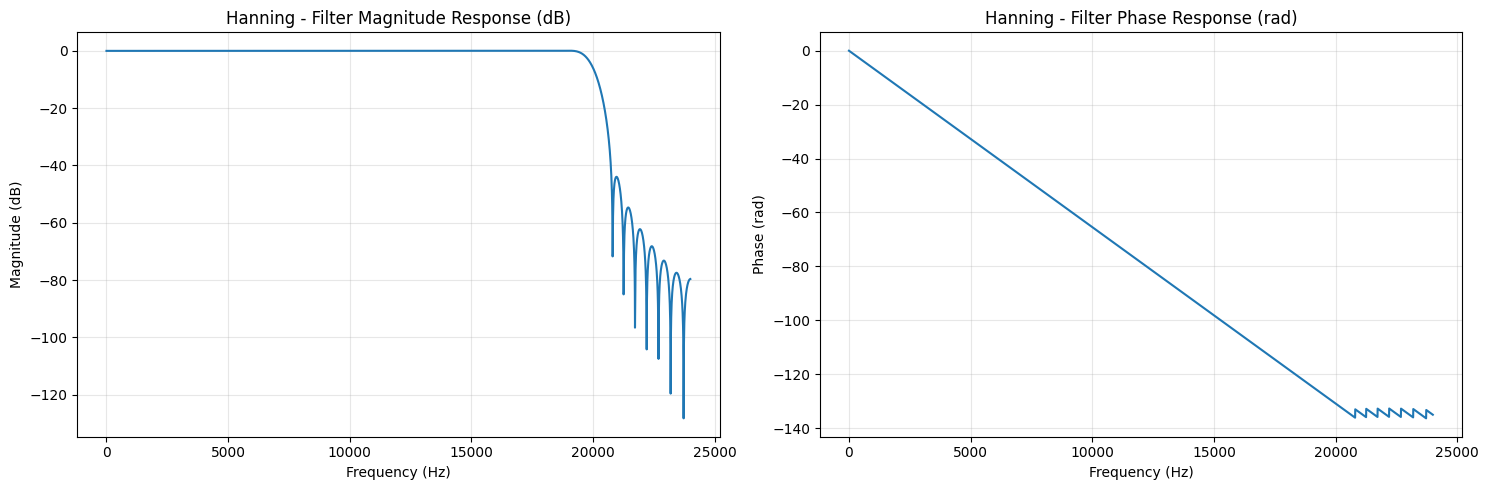

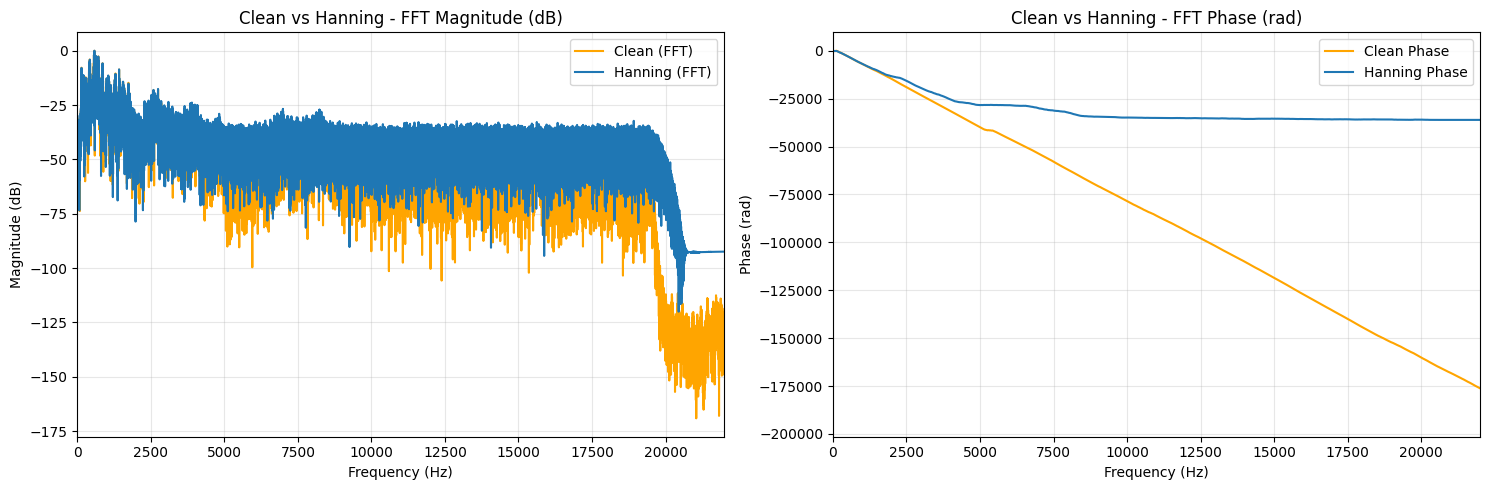

SNR for Hamming: 15.91 dB


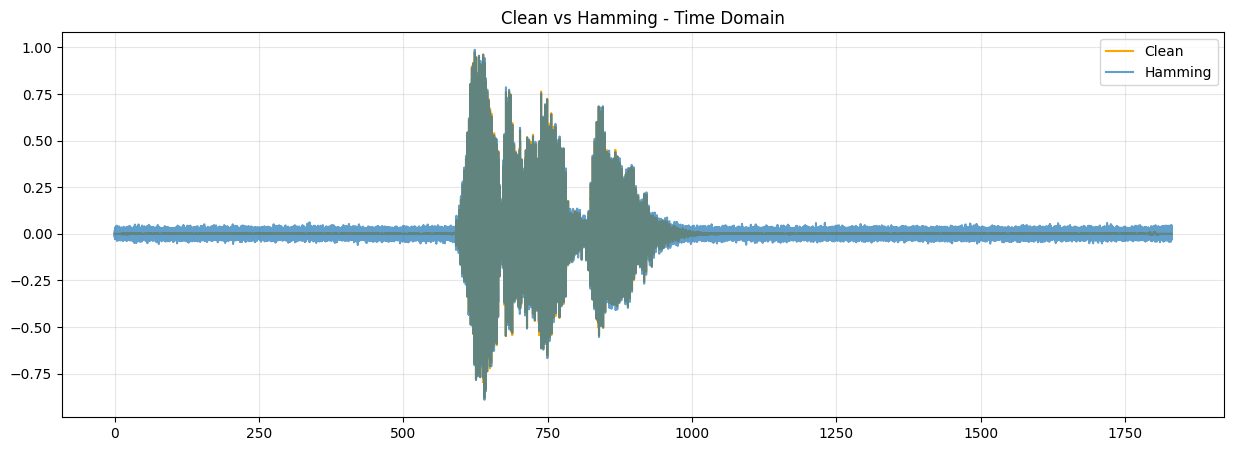

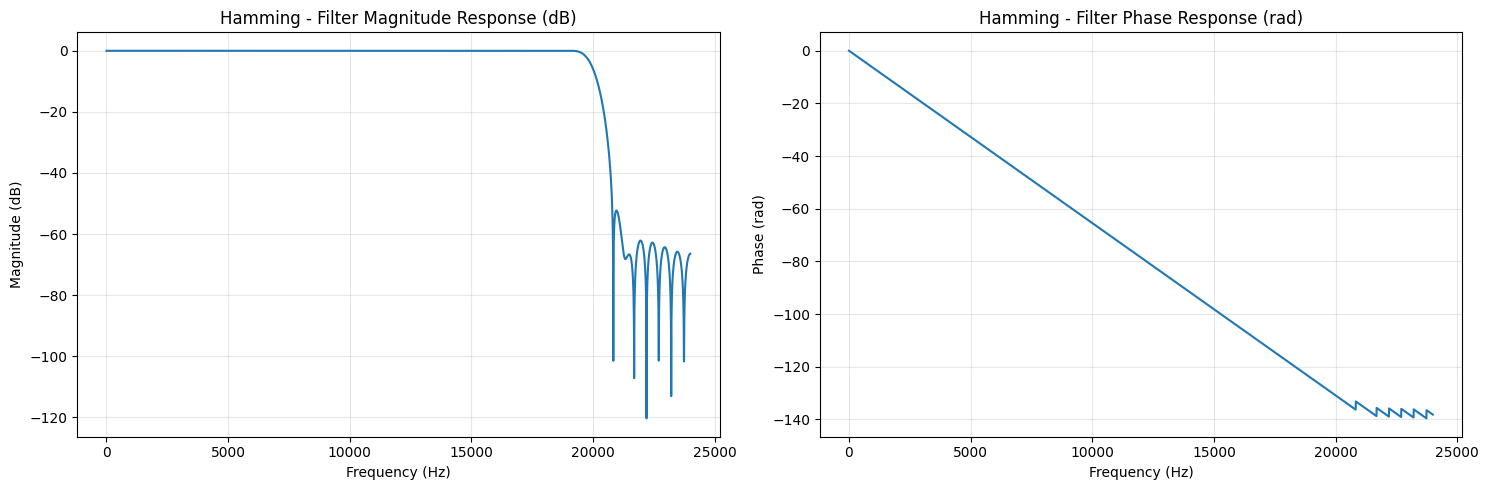

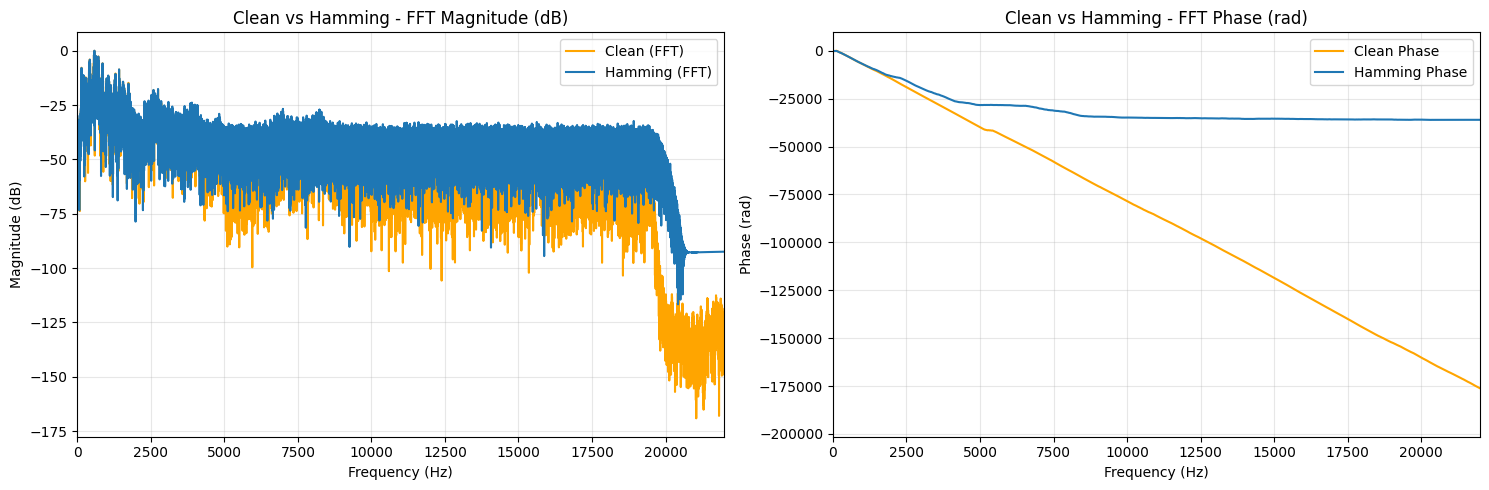

SNR for Blackman: 15.94 dB


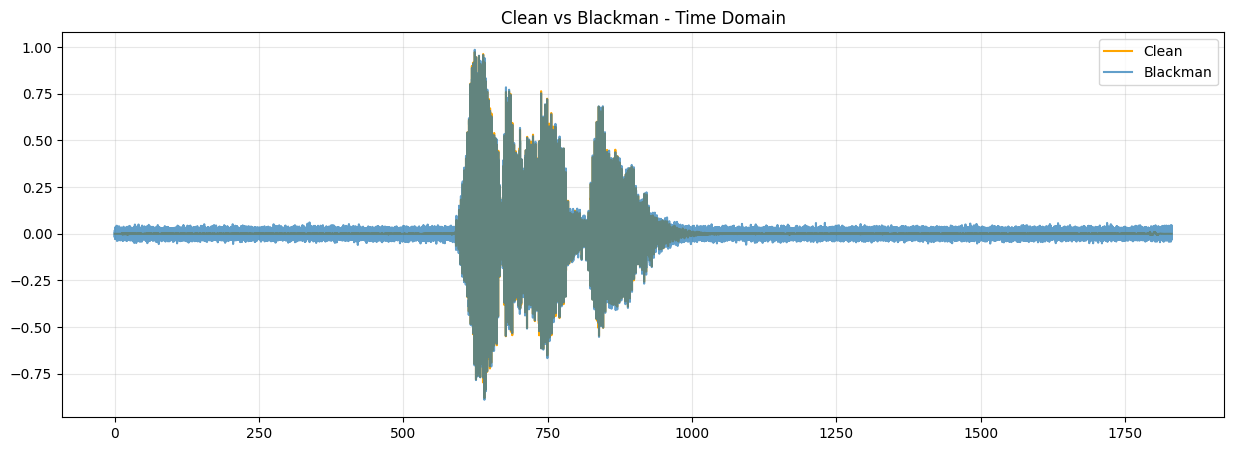

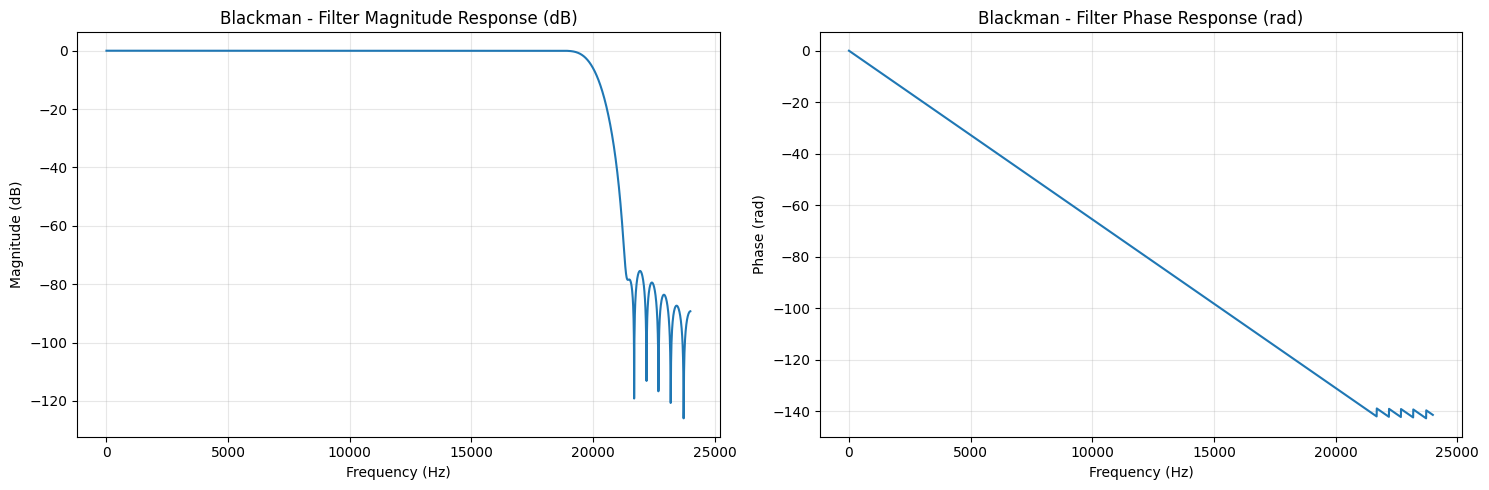

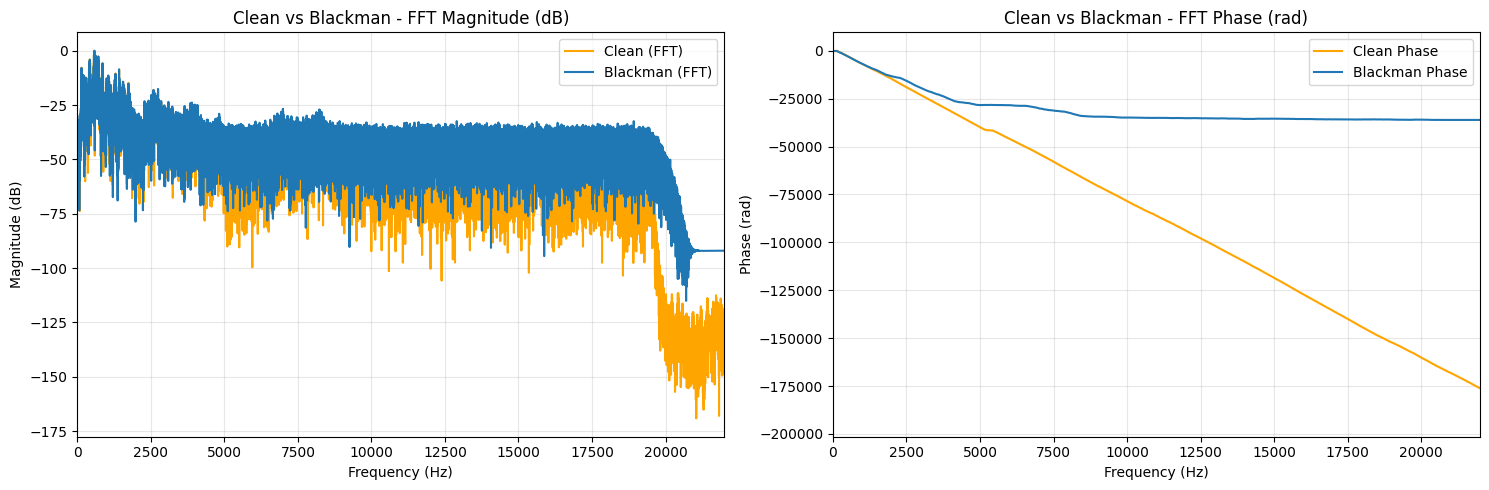

SNR for Kaiser: 15.88 dB


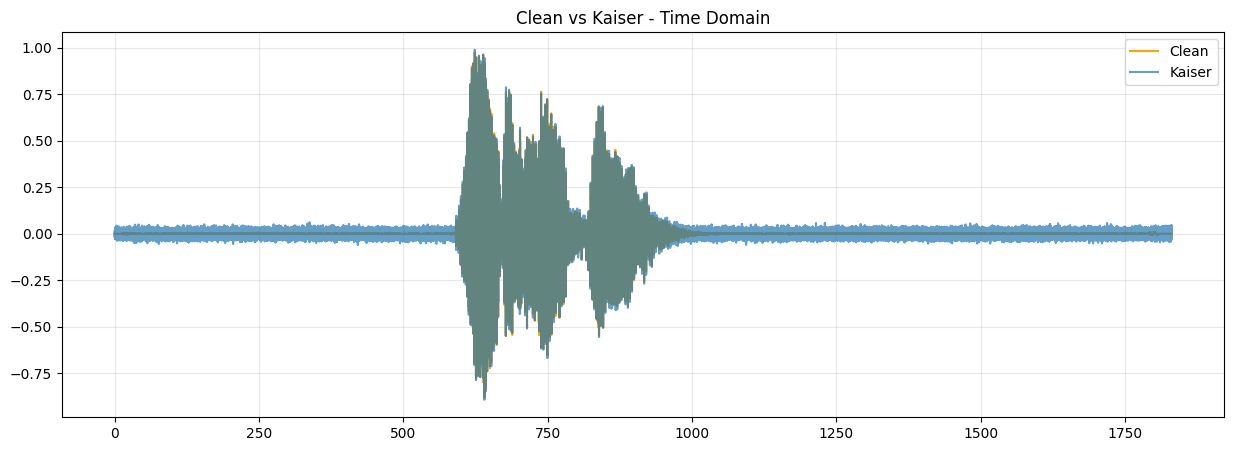

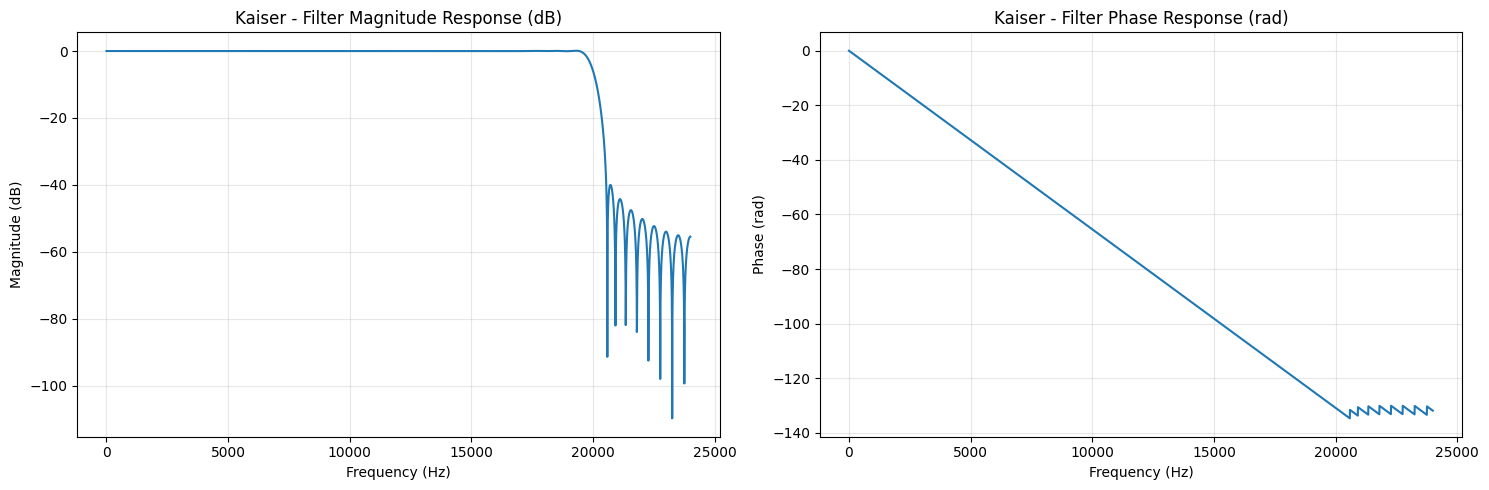

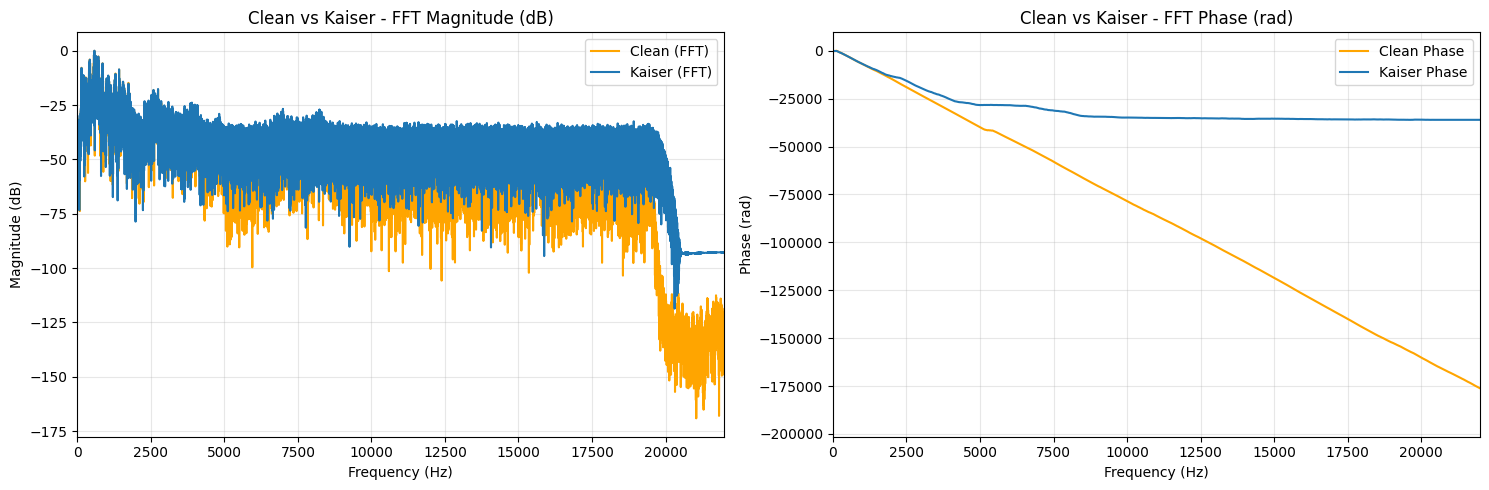

In [17]:
#After the class presentation, the phase response was also added to complete the analysis and provide a more comprehensive evaluation of the filter performance



from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display

audio_path = "/content/whatever.mp3"
clean_audio, sr = librosa.load(audio_path, sr=None, mono=True)

fnyquist = sr / 2
fp = 0          # start frequency (Hz)
fend = 20000    # end frequency (Hz)

# Since fp = 0 → LOWPASS filter
cutoff = fend   # single cutoff frequency

# Transition width (normalized)
width = 300 / fnyquist

ripple_dB = 40
N, beta = signal.kaiserord(ripple_dB, width)

t = librosa.frames_to_time(range(len(noisy_signal)), sr=sr)

# ===============================
# Liste des fenêtres
# ===============================
window_names = {
    "Rectangulaire": "boxcar",
    "Triangulaire": "bartlett",
    "Parabolic": "parzen",
    "Polynomial": "blackmanharris",
    "Cosine": "cosine",
    "Hanning": "hann",
    "Hamming": "hamming",
    "Blackman": "blackman",
    "Kaiser": ("kaiser", beta)
}

filtered_signals = {}

eps = 1e-12

# ===============================
# Appliquer chaque fenêtre
# ===============================
for name, window in window_names.items():

    filt = signal.firwin(
        numtaps=101,
        cutoff=cutoff,
        pass_zero=True,     # LOWPASS because fp = 0
        window=window,
        fs=sr
    )

    filtered_audio = signal.filtfilt(filt, 1, noisy_signal)
    filtered_signals[name] = filtered_audio

    # ===============================
    # Calcul SNR
    # ===============================
    signal_power = np.mean(clean_audio ** 2)
    noise_power = np.mean((clean_audio - filtered_audio) ** 2)
    snr = 10 * np.log10(signal_power / max(noise_power, 1e-20))
    print(f"SNR for {name}: {snr:.2f} dB")

    # ===============================
    # Sauvegarde audio
    # ===============================
    sf.write(f"{name}_audio.wav", filtered_audio, sr)

    # ===============================
    # Domaine temporel
    # ===============================
    plt.figure(figsize=(15, 5))
    plt.plot(t, clean_audio, label="Clean", color="orange")
    plt.plot(t, filtered_audio, alpha=0.7, label=name)
    plt.title(f"Clean vs {name} - Time Domain")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ==========================================================
    # (NEW) FILTER RESPONSE using freqz: MAGNITUDE + PHASE ✅
    # ==========================================================
    w, Hf = signal.freqz(filt, worN=4096, fs=sr)   # response of the FILTER

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(w, 20*np.log10(np.maximum(np.abs(Hf), eps)))
    plt.title(f"{name} - Filter Magnitude Response (dB)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(w, np.unwrap(np.angle(Hf)))
    plt.title(f"{name} - Filter Phase Response (rad)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (rad)")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # (NEW) SIGNAL FFT: MAGNITUDE + PHASE (clean vs filtered) ✅
    # ==========================================================
    Nsig = len(clean_audio)
    freqs = np.fft.rfftfreq(Nsig, d=1/sr)

    FFT_clean = np.fft.rfft(clean_audio)
    FFT_filt  = np.fft.rfft(filtered_audio)

    # magnitude in dB (ref max of clean)
    ref = np.max(np.abs(FFT_clean)) + eps
    mag_clean_db = 20*np.log10(np.abs(FFT_clean) / ref + eps)
    mag_filt_db  = 20*np.log10(np.abs(FFT_filt)  / ref + eps)

    phase_clean = np.unwrap(np.angle(FFT_clean))
    phase_filt  = np.unwrap(np.angle(FFT_filt))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(freqs, mag_clean_db, color="orange", label="Clean (FFT)")
    plt.plot(freqs, mag_filt_db, label=f"{name} (FFT)")
    plt.title(f"Clean vs {name} - FFT Magnitude (dB)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.xlim(0, min(22000, fnyquist))
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(freqs, phase_clean, color="orange", label="Clean Phase")
    plt.plot(freqs, phase_filt, label=f"{name} Phase")
    plt.title(f"Clean vs {name} - FFT Phase (rad)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (rad)")
    plt.xlim(0, min(22000, fnyquist))
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


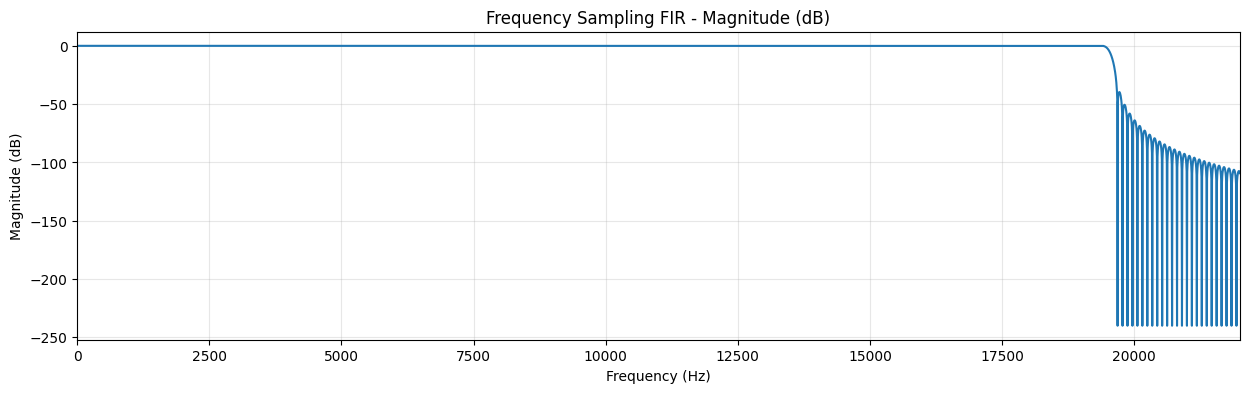

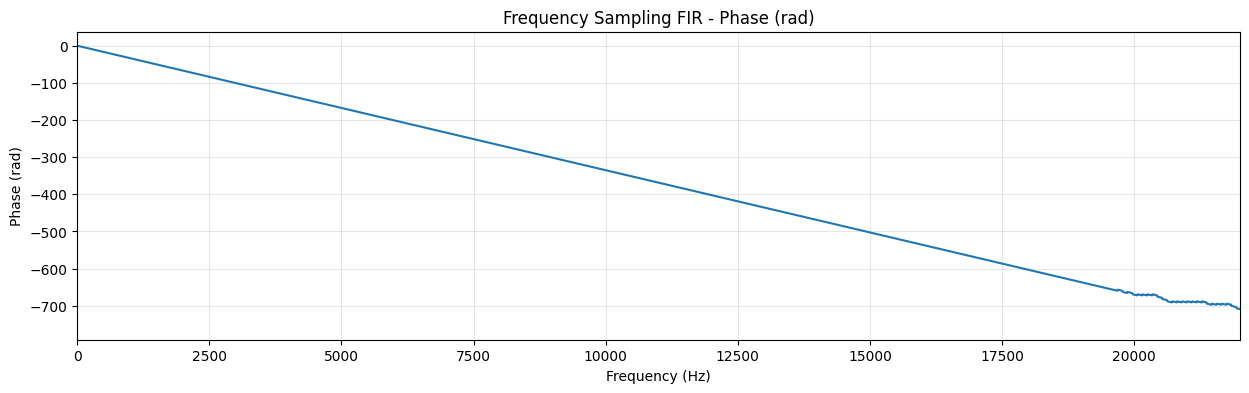

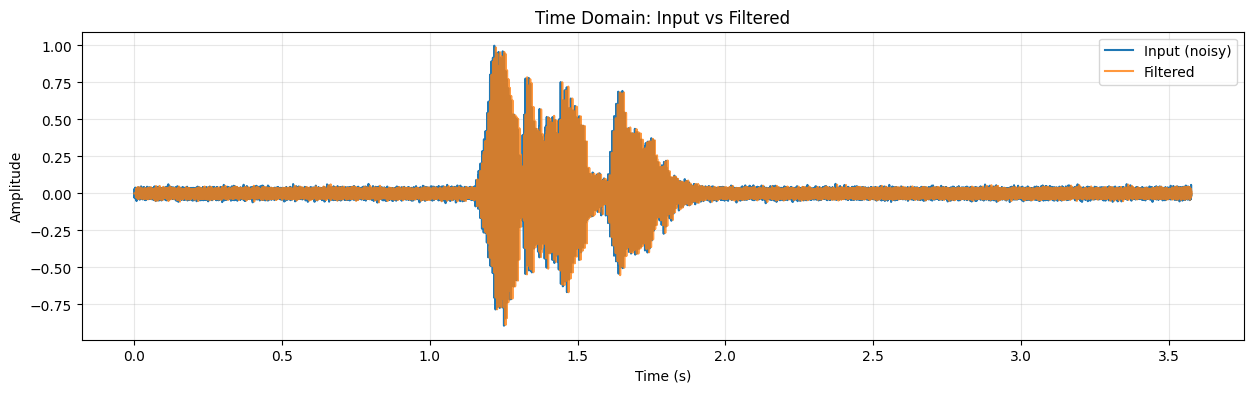

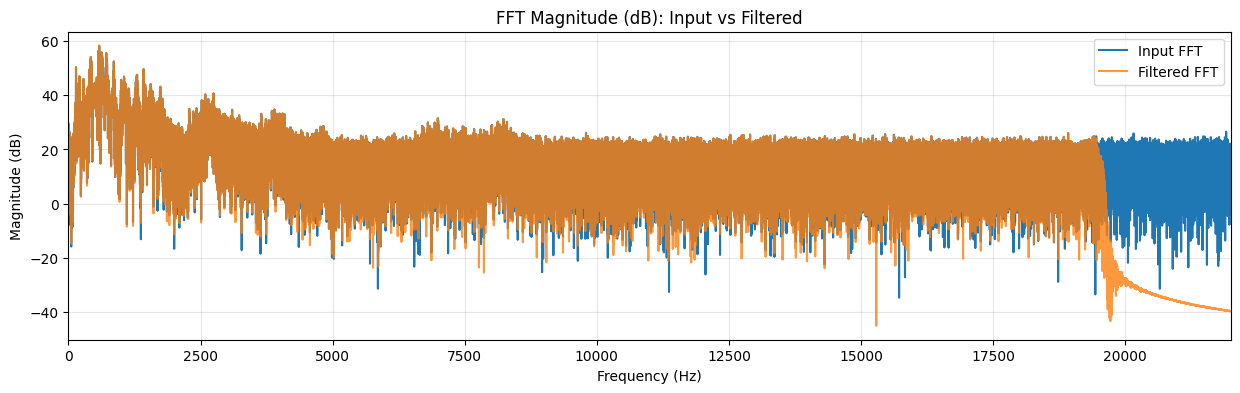

SNR = 15.95 dB


In [20]:



#After the class presentation, the phase response was also added to complete the analysis and provide a more comprehensive evaluation of the filter performance
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ===============================
# Frequency Sampling FIR (LOWPASS)
# fc_b = 0, fc_h = 19500
# ===============================
def fir_freq_sampling_lowpass(sr, fc_h, N):
    """
    Build H[k] (ideal lowpass samples) on N bins,
    h_d[n] = IFFT(H[k]) (non-causal),
    shift by N/2 (N even) -> causal linear-phase FIR.
    """
    if N % 2 != 0:
        raise ValueError("Choose N EVEN so shifting by N/2 works.")

    fnyq = sr / 2
    fc_h = min(fc_h, fnyq - 1e-6)

    # Frequency grid of DFT bins (Hz), includes negative freqs
    f = np.fft.fftfreq(N, d=1/sr)

    # Ideal lowpass samples: 1 for |f| <= fc_h
    H = np.zeros(N, dtype=complex)
    H[np.abs(f) <= fc_h] = 1.0

    # Enforce conjugate symmetry -> real impulse response
    H = (H + np.conj(H[::-1])) / 2
    H[0] = np.real(H[0]) + 0j
    if N % 2 == 0:
        H[N//2] = np.real(H[N//2]) + 0j

    # Non-causal impulse response
    h_d = np.fft.ifft(H).real

    # Make causal + linear phase
    h = np.roll(h_d, N//2)

    return h


# ===============================
# APPLY TO YOUR SIGNAL
# ===============================
x = noisy_signal
t = np.arange(len(x)) / sr

fc_h = 19500
N = 512   # increase N -> sharper transition (try 256, 512, 1024)

h = fir_freq_sampling_lowpass(sr, fc_h, N)

# FIR filtering
y = signal.lfilter(h, [1.0], x)

# ===============================
# FILTER RESPONSE: MAG + PHASE
# ===============================
w, Hf = signal.freqz(h, worN=4096, fs=sr)

plt.figure(figsize=(15, 4))
plt.plot(w, 20*np.log10(np.maximum(np.abs(Hf), 1e-12)))
plt.title("Frequency Sampling FIR - Magnitude (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, min(sr/2, 22000))
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(15, 4))
plt.plot(w, np.unwrap(np.angle(Hf)))
plt.title("Frequency Sampling FIR - Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (rad)")
plt.xlim(0, min(sr/2, 22000))
plt.grid(True, alpha=0.3)
plt.show()

# ===============================
# TIME DOMAIN
# ===============================
plt.figure(figsize=(15, 4))
plt.plot(t, x, label="Input (noisy)")
plt.plot(t, y, label="Filtered", alpha=0.8)
plt.title("Time Domain: Input vs Filtered")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ===============================
# FFT MAGNITUDE
# ===============================
def fft_mag_db(sig, sr):
    Nsig = len(sig)
    Nfft = 2**int(np.ceil(np.log2(Nsig)))
    f = np.fft.rfftfreq(Nfft, d=1/sr)
    X = np.fft.rfft(sig, n=Nfft)
    mag_db = 20*np.log10(np.maximum(np.abs(X), 1e-12))
    return f, mag_db

f_in,  mag_in  = fft_mag_db(x, sr)
f_out, mag_out = fft_mag_db(y, sr)

plt.figure(figsize=(15, 4))
plt.plot(f_in, mag_in, label="Input FFT")
plt.plot(f_out, mag_out, label="Filtered FFT", alpha=0.8)
plt.title("FFT Magnitude (dB): Input vs Filtered")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, min(sr/2, 22000))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
delay = N // 2
y_aligned = y[delay:]
clean_aligned = clean_audio[:len(y_aligned)]

signal_power = np.mean(clean_aligned ** 2)
noise_power  = np.mean((clean_aligned - y_aligned) ** 2)

snr = 10 * np.log10(signal_power / noise_power)
print(f"SNR = {snr:.2f} dB")


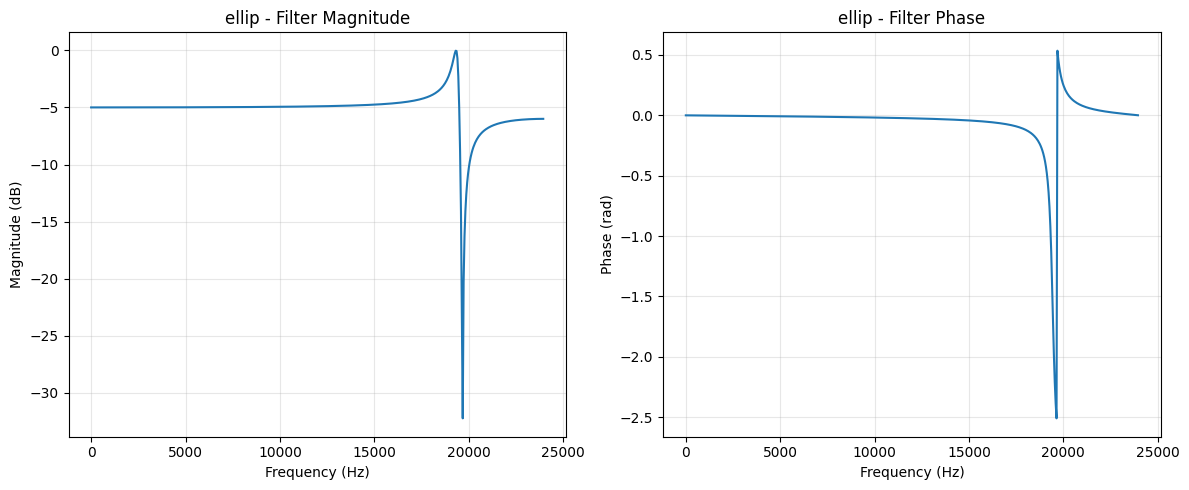

SNR for ellip: 3.27 dB


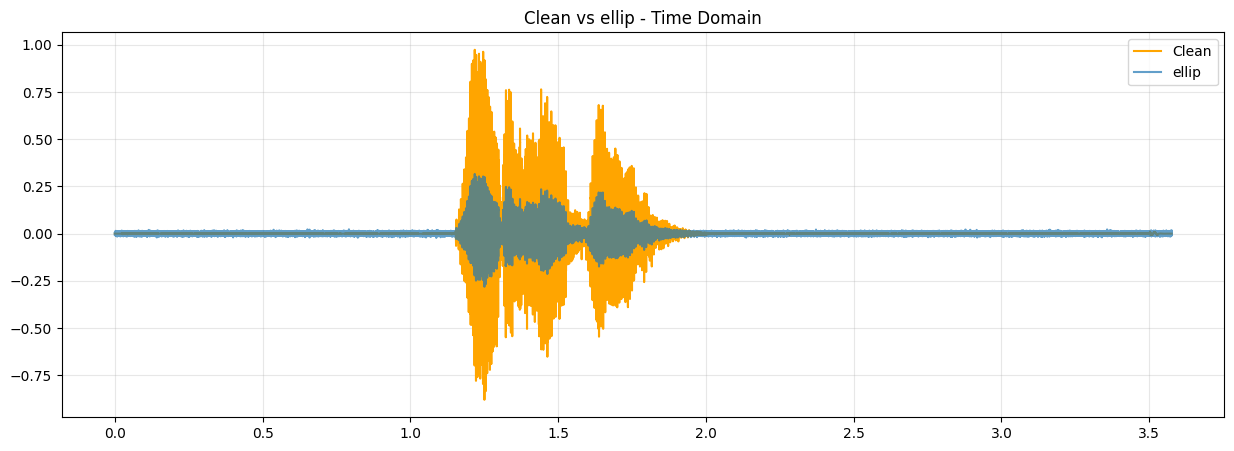

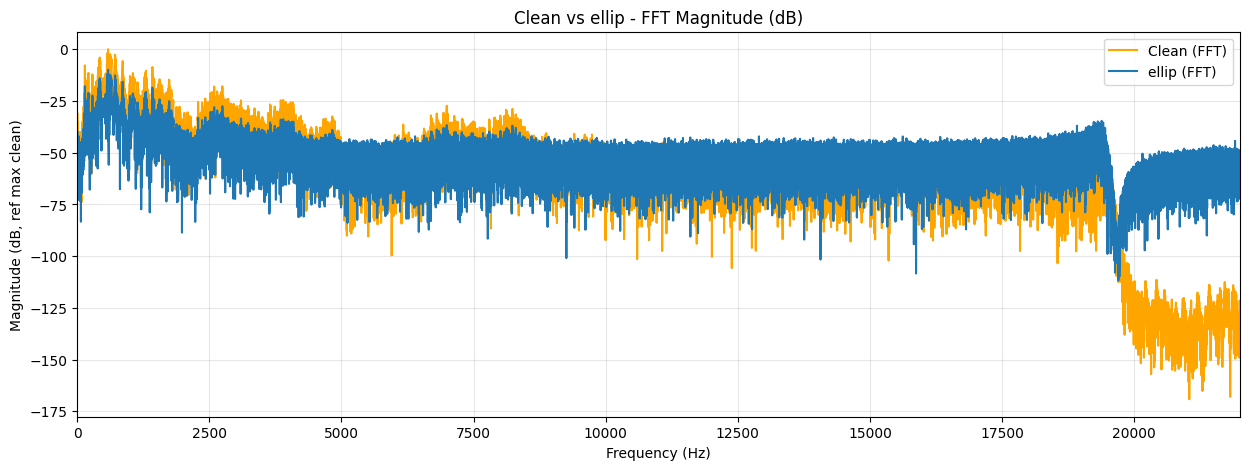

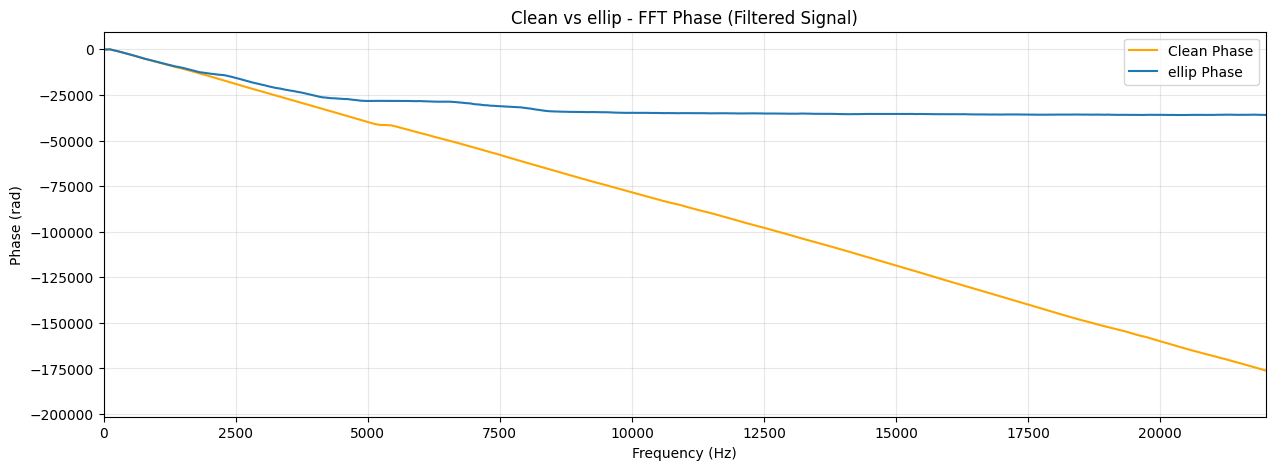

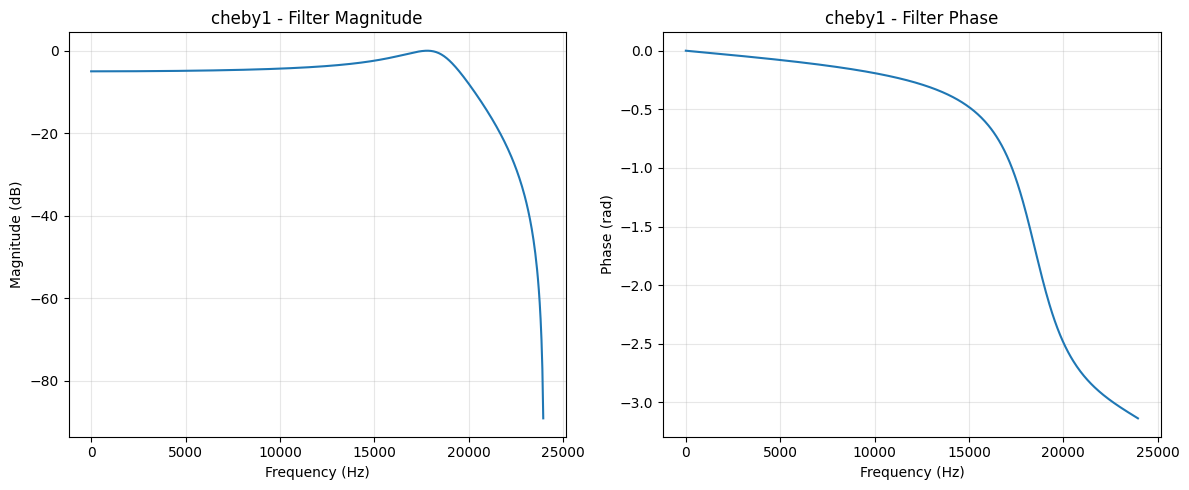

SNR for cheby1: 3.25 dB


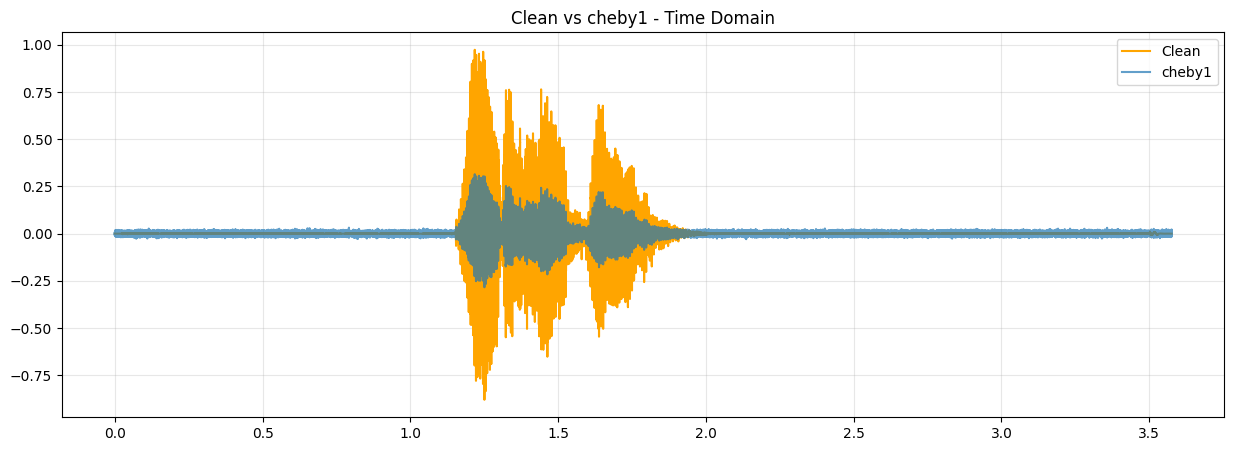

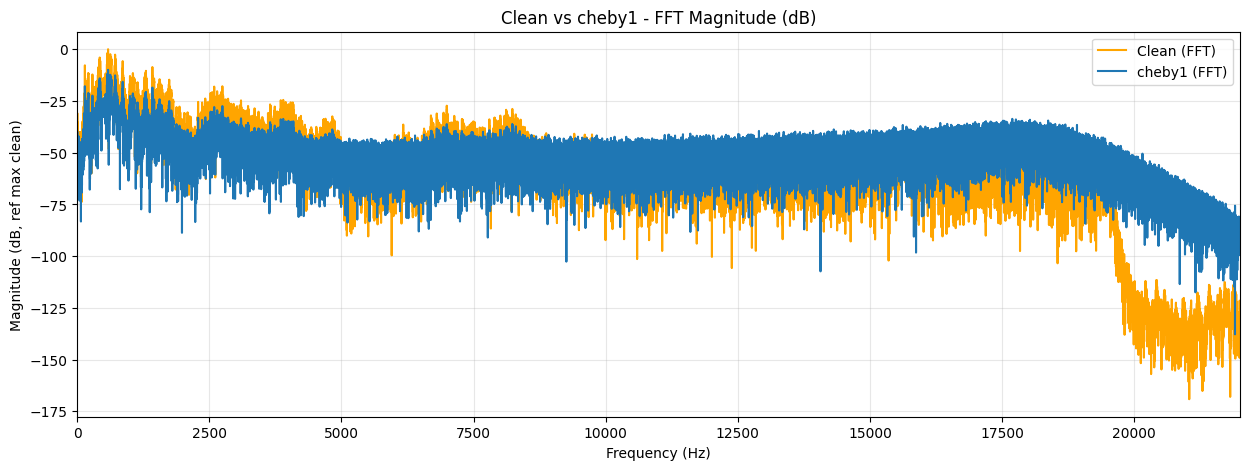

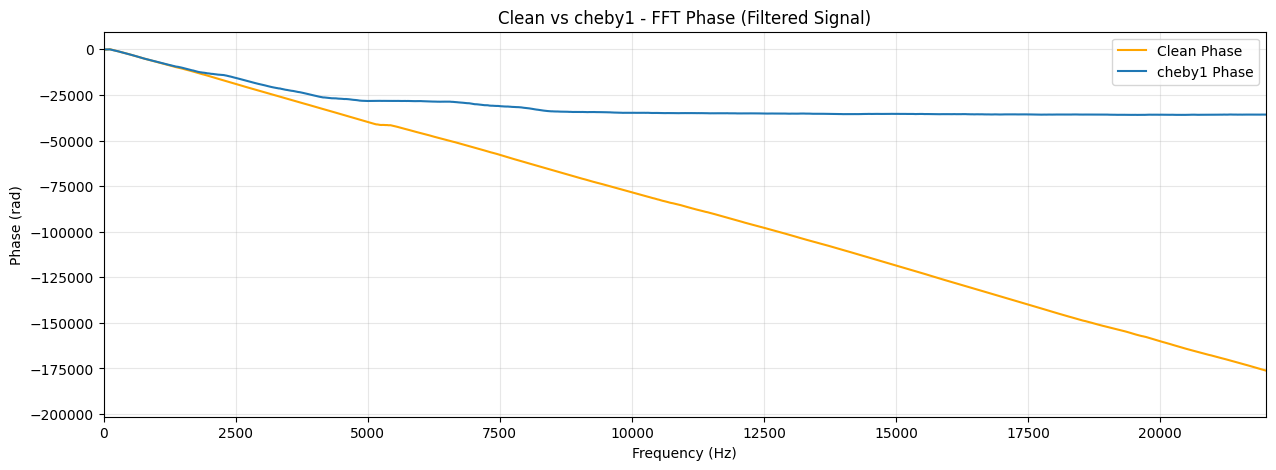

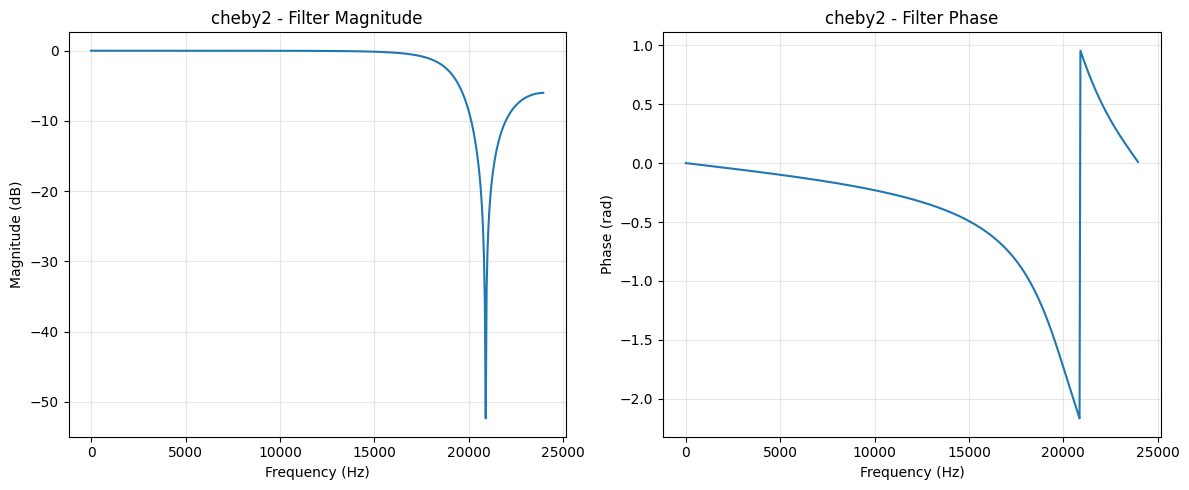

SNR for cheby2: 16.31 dB


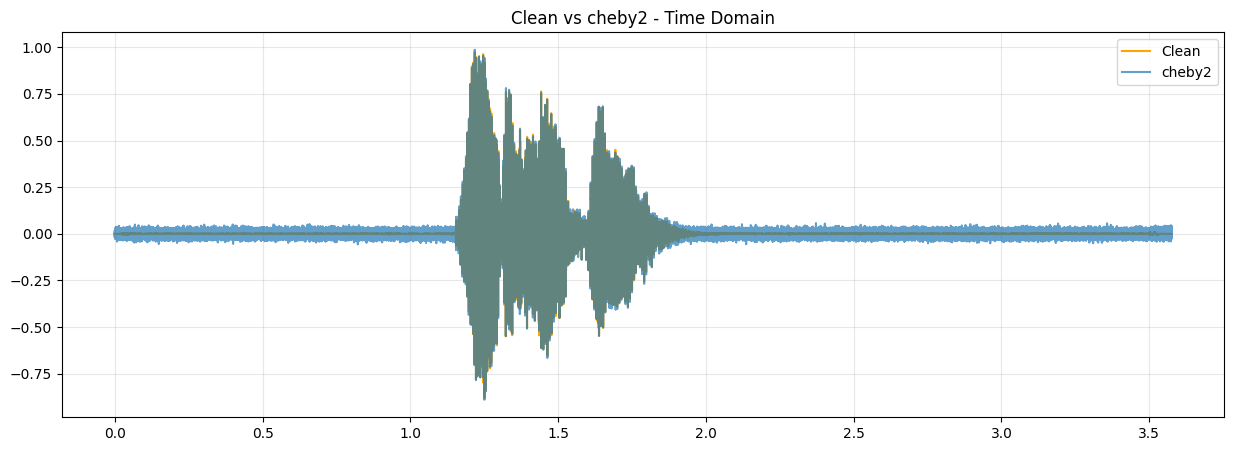

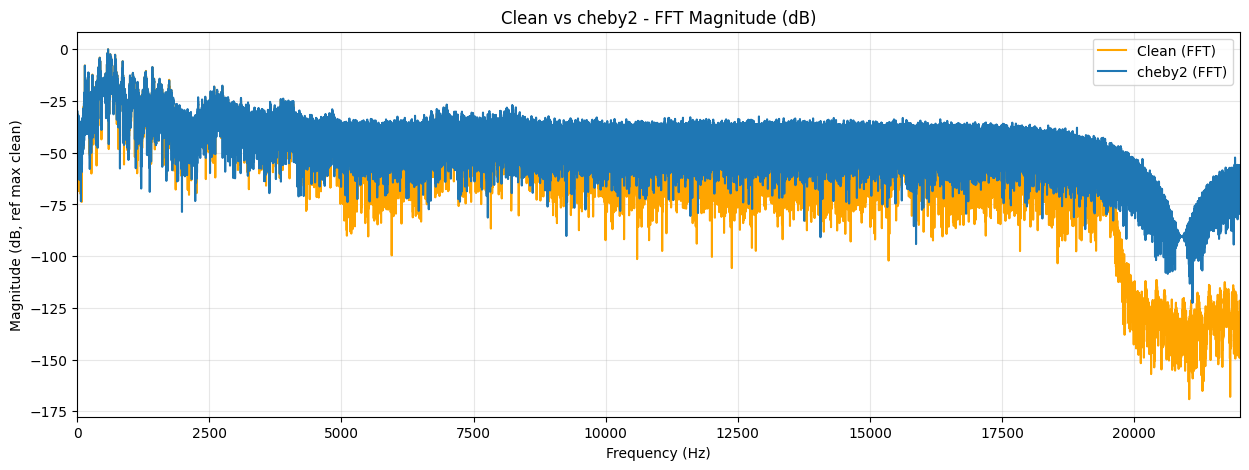

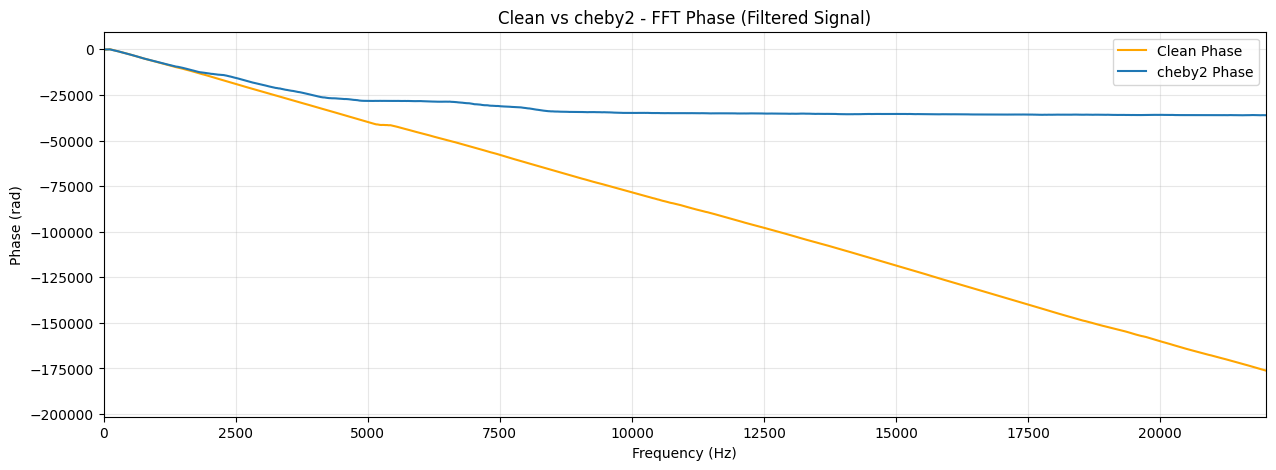

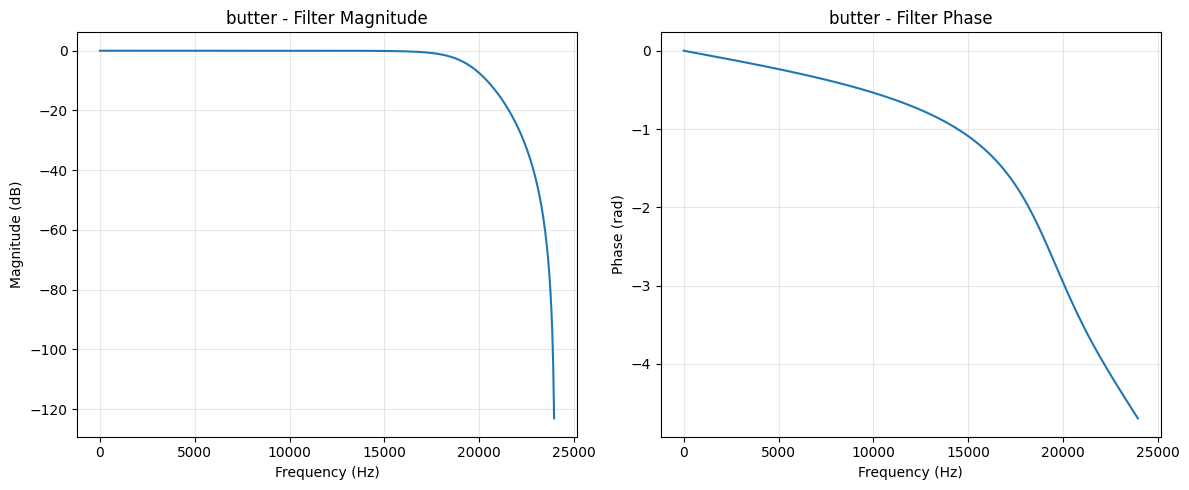

SNR for butter: 16.30 dB


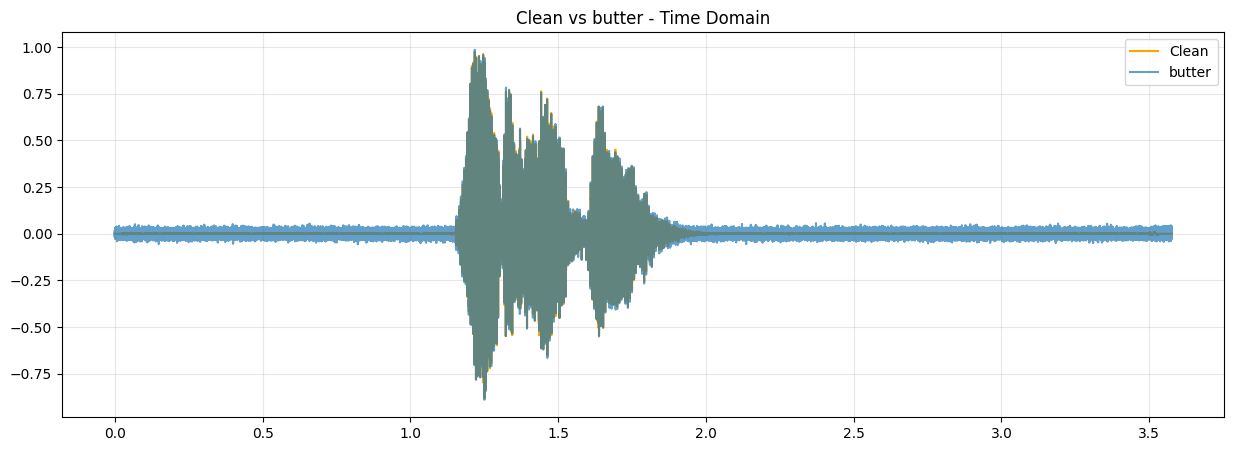

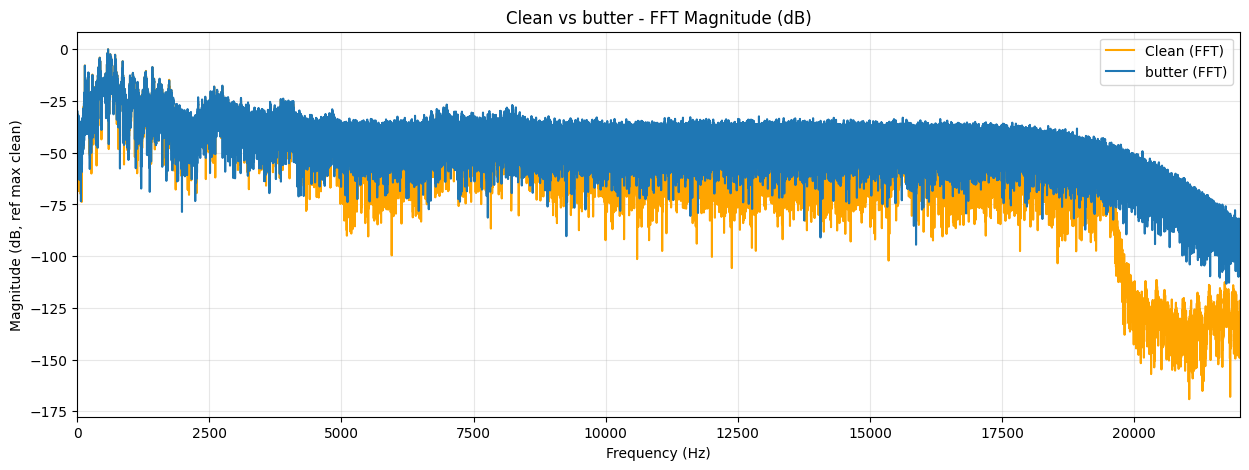

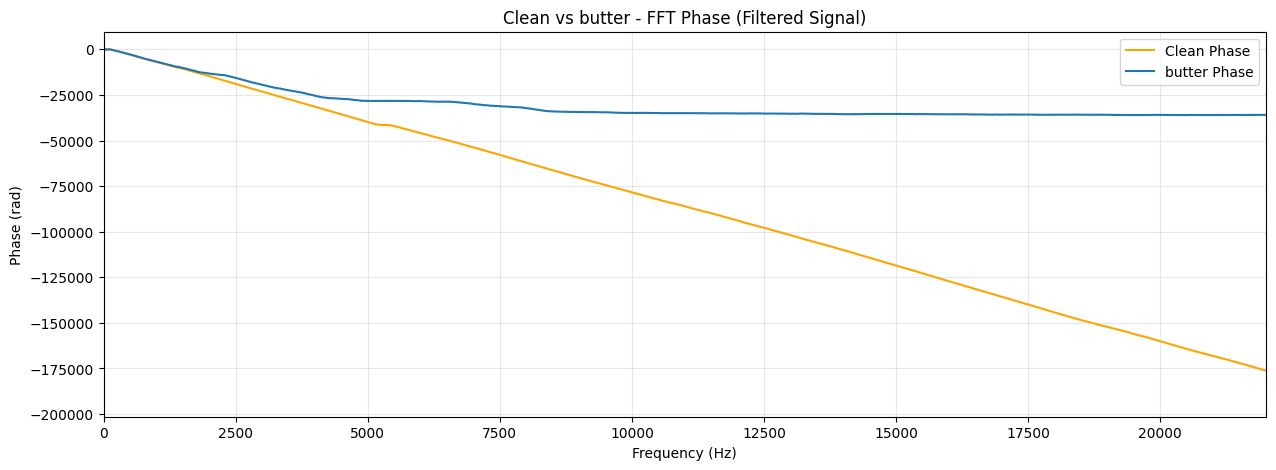


RÉSULTATS FILTRES IIR
Meilleur filtre: cheby2 avec SNR = 16.31 dB
Pire filtre: cheby1 avec SNR = 3.25 dB

SNR sorted (lowest → highest):
------------------------------------------------------------
cheby1              :    3.25 dB
ellip               :    3.27 dB
butter              :   16.30 dB
cheby2              :   16.31 dB


In [15]:
# ===============================
#After the class presentation, the phase response was also added to complete the analysis and provide a more comprehensive evaluation of the filter performance








# LOWPASS IIR FILTERS
# - Compute N first using *_ord (ellipord / cheb1ord / cheb2ord / buttord)
# - Design SOS with iirfilter
# - Apply filtering (sosfiltfilt)
# - Plot:
#   1) Filter magnitude + filter phase
#   2) Time domain (clean vs filtered)
#   3) FFT magnitude (clean vs filtered)
#   4) FFT PHASE of filtered signal (clean vs filtered)   ✅
# ===============================

from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

fnyquist = sr / 2
fc_b = 0
fc_h = 19500

# Since fc_b = 0, use lowpass filter (single cutoff)
cutoff = min(fc_h, fnyquist - 1)

rii_filters = ['ellip', 'cheby1', 'cheby2', 'butter']  # cauer = ellip
rii = {}
snr_iir = {}

eps = 1e-12  # avoid log(0)

# ===============================
# Specs for ORDER computation
# (these control how big N becomes)
# ===============================
rp = 5   # passband ripple (dB)
rs = 6   # stopband attenuation (dB)

transition_hz = 300
ws_hz = min(fnyquist - 1, cutoff + transition_hz)

Wp = cutoff / fnyquist     # passband edge (normalized)
Ws = ws_hz / fnyquist      # stopband edge (normalized)

for name in rii_filters:

    # ===============================
    # 1) Compute N and Wn first
    # ===============================
    if name == 'ellip':
        N, Wn = signal.ellipord(Wp, Ws, rp, rs)
    elif name == 'cheby1':
        N, Wn = signal.cheb1ord(Wp, Ws, rp, rs)
    elif name == 'cheby2':
        N, Wn = signal.cheb2ord(Wp, Ws, rp, rs)
    else:  # butter
        N, Wn = signal.buttord(Wp, Ws, rp, rs)

    # ===============================
    # 2) Design SOS filter using that N
    # ===============================
    if name == 'cheby1':
        filt = signal.iirfilter(N, Wn, btype='low', ftype=name, output='sos', rp=rp)
    elif name == 'cheby2':
        filt = signal.iirfilter(N, Wn, btype='low', ftype=name, output='sos', rs=rs)
    elif name == 'ellip':
        filt = signal.iirfilter(N, Wn, btype='low', ftype=name, output='sos', rp=rp, rs=rs)
    else:  # butter
        filt = signal.iirfilter(N, Wn, btype='low', ftype=name, output='sos')

    # ===============================
    # 3) Filter response: Magnitude + Phase (FILTER)
    # ===============================
    w, H = signal.sosfreqz(filt, fs=sr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(w, 20 * np.log10(np.maximum(np.abs(H), eps)))
    plt.title(f"{name} - Filter Magnitude")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(w, np.unwrap(np.angle(H)))
    plt.title(f"{name} - Filter Phase")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (rad)")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ===============================
    # 4) Apply filtering (zero-phase)
    # ===============================
    filtered_audio = signal.sosfiltfilt(filt, noisy_signal)
    rii[name] = filtered_audio

    # ===============================
    # 5) SNR
    # ===============================
    signal_power = np.mean(clean_audio ** 2)
    noise_power = np.mean((clean_audio - filtered_audio) ** 2)
    snr = 10 * np.log10(signal_power / max(noise_power, 1e-20))
    snr_iir[name] = snr
    print(f"SNR for {name}: {snr:.2f} dB")

    # ===============================
    # 6) Save filtered audio
    # ===============================
    sf.write(f"{name}_audio.wav", filtered_audio, sr)

    # ===============================
    # 7) Time domain plot
    # ===============================
    t = np.arange(len(noisy_signal)) / sr
    plt.figure(figsize=(15, 5))
    plt.plot(t, clean_audio, label="Clean", color="orange")
    plt.plot(t, filtered_audio, alpha=0.7, label=f"{name}")
    plt.title(f"Clean vs {name} - Time Domain")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ===============================
    # 8) FFT magnitude + phase (SIGNALS)
    # ===============================
    Nsig = len(clean_audio)
    freqs = np.fft.rfftfreq(Nsig, d=1/sr)

    FFT_clean = np.fft.rfft(clean_audio)
    FFT_filt  = np.fft.rfft(filtered_audio)

    # magnitude (dB ref max clean)
    ref = np.max(np.abs(FFT_clean)) + eps
    mag_clean_db = 20 * np.log10(np.abs(FFT_clean) / ref + eps)
    mag_filt_db  = 20 * np.log10(np.abs(FFT_filt)  / ref + eps)

    plt.figure(figsize=(15, 5))
    plt.plot(freqs, mag_clean_db, color="orange", label="Clean (FFT)")
    plt.plot(freqs, mag_filt_db, label=f"{name} (FFT)")
    plt.title(f"Clean vs {name} - FFT Magnitude (dB)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB, ref max clean)")
    plt.xlim(0, 22000)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ===============================
    # 9) FFT PHASE of filtered signal ✅
    # ===============================
    phase_clean = np.unwrap(np.angle(FFT_clean))
    phase_filt  = np.unwrap(np.angle(FFT_filt))

    plt.figure(figsize=(15, 5))
    plt.plot(freqs, phase_clean, color="orange", label="Clean Phase")
    plt.plot(freqs, phase_filt, label=f"{name} Phase")
    plt.title(f"Clean vs {name} - FFT Phase (Filtered Signal)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (rad)")
    plt.xlim(0, 22000)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ===============================
# Print results
# ===============================
best_iir = max(snr_iir, key=snr_iir.get)
worst_iir = min(snr_iir, key=snr_iir.get)

print("\n" + "="*60)
print("RÉSULTATS FILTRES IIR")
print("="*60)
print(f"Meilleur filtre: {best_iir} avec SNR = {snr_iir[best_iir]:.2f} dB")
print(f"Pire filtre: {worst_iir} avec SNR = {snr_iir[worst_iir]:.2f} dB")
print("="*60)

print("\nSNR sorted (lowest → highest):")
print("-"*60)
for n, s in sorted(snr_iir.items(), key=lambda x: x[1]):
    print(f"{n:20s}: {s:7.2f} dB")
print("="*60)
